# Libraries & Configuration

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.layers import CuDNNLSTM, Activation, Bidirectional, Dropout, Dense
from keras.models import Sequential 
from keras.callbacks import EarlyStopping

# configurations
%matplotlib inline
%config InlineBackend.figure_format='retina'
# add 2x retina display config
# https://github.com/ipython/ipython/pull/3381


# `pd.Timestamp` can be used in matplotlib plots without having to cast them to another type
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.register_matplotlib_converters.html
pd.plotting.register_matplotlib_converters()

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
plt.rcParams['figure.figsize'] = 20, 9


RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


# Load Dataset

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset
!kaggle datasets download -d hmavrodiev/london-bike-sharing-dataset
!unzip /content/london-bike-sharing-dataset.zip

  0% 0.00/165k [00:00<?, ?B/s]
100% 165k/165k [00:00<00:00, 38.6MB/s]
Archive:  /content/london-bike-sharing-dataset.zip
  inflating: london_merged.csv       


# EDA

**Dataset Overview**

* timestamp - timestamp field for grouping the data
* cnt - the count of a new bike shares
* t1 - real temperature in C
* t2 - temperature in C “feels like”
* hum - humidity in percentage
* wind_speed - wind speed in km/h
* weather_code - category of the weather
* is_holiday - boolean field - 1 holiday / 0 non holiday
* is_weekend - boolean field - 1 if the day is weekend
* season - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter

"weather_code" category description:

1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity \\
2 = scattered clouds / few clouds \\
3 = Broken clouds \\
4 = Cloudy \\
7 = Rain/ light Rain shower/ Light rain \\
10 = rain with thunderstorm \\
26 = snowfall \\
94 = Freezing Fog \\

predict future demand based on the data

In [4]:
df_pbs = pd.read_csv('/content/london_merged.csv', 
                     parse_dates=['timestamp'],
                     index_col='timestamp')
df_pbs

cnt   t1   t2  ...  is_holiday  is_weekend  season
timestamp                            ...                                
2015-01-04 00:00:00   182  3.0  2.0  ...         0.0         1.0     3.0
2015-01-04 01:00:00   138  3.0  2.5  ...         0.0         1.0     3.0
2015-01-04 02:00:00   134  2.5  2.5  ...         0.0         1.0     3.0
2015-01-04 03:00:00    72  2.0  2.0  ...         0.0         1.0     3.0
2015-01-04 04:00:00    47  2.0  0.0  ...         0.0         1.0     3.0
...                   ...  ...  ...  ...         ...         ...     ...
2017-01-03 19:00:00  1042  5.0  1.0  ...         0.0         0.0     3.0
2017-01-03 20:00:00   541  5.0  1.0  ...         0.0         0.0     3.0
2017-01-03 21:00:00   337  5.5  1.5  ...         0.0         0.0     3.0
2017-01-03 22:00:00   224  5.5  1.5  ...         0.0         0.0     3.0
2017-01-03 23:00:00   139  5.0  1.0  ...         0.0         0.0     3.0

[17414 rows x 9 columns]

In [ ]:
df_pbs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   weather_code  17414 non-null  float64
 6   is_holiday    17414 non-null  float64
 7   is_weekend    17414 non-null  float64
 8   season        17414 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


In [ ]:
df_pbs.describe().T

count         mean          std  ...    50%      75%     max
cnt           17414.0  1143.101642  1085.108068  ...  844.0  1671.75  7860.0
t1            17414.0    12.468091     5.571818  ...   12.5    16.00    34.0
t2            17414.0    11.520836     6.615145  ...   12.5    16.00    34.0
hum           17414.0    72.324954    14.313186  ...   74.5    83.00   100.0
wind_speed    17414.0    15.913063     7.894570  ...   15.0    20.50    56.5
weather_code  17414.0     2.722752     2.341163  ...    2.0     3.00    26.0
is_holiday    17414.0     0.022051     0.146854  ...    0.0     0.00     1.0
is_weekend    17414.0     0.285403     0.451619  ...    0.0     1.00     1.0
season        17414.0     1.492075     1.118911  ...    1.0     2.00     3.0

[9 rows x 8 columns]

## Missing Values

In [ ]:
pd.date_range(df_pbs.index.min(), df_pbs.index.max()).difference(df_pbs.index)

DatetimeIndex(['2015-09-12', '2015-11-18', '2016-02-08', '2016-06-24',
               '2016-07-31', '2016-09-02', '2016-09-03'],
              dtype='datetime64[ns]', freq=None)

Since the ratio of missing dates is very low (~0.1%), no action is taken to fill missing values

## Feature Extraction

In [5]:
# add hour of the day 
df_pbs['hour'] = df_pbs.index.hour

# add day of month
df_pbs['day_of_month'] = df_pbs.index.day

# add day of week
df_pbs['day_of_week'] = df_pbs.index.dayofweek

# add month
df_pbs['month'] = df_pbs.index.month

## Bike Share Over Time

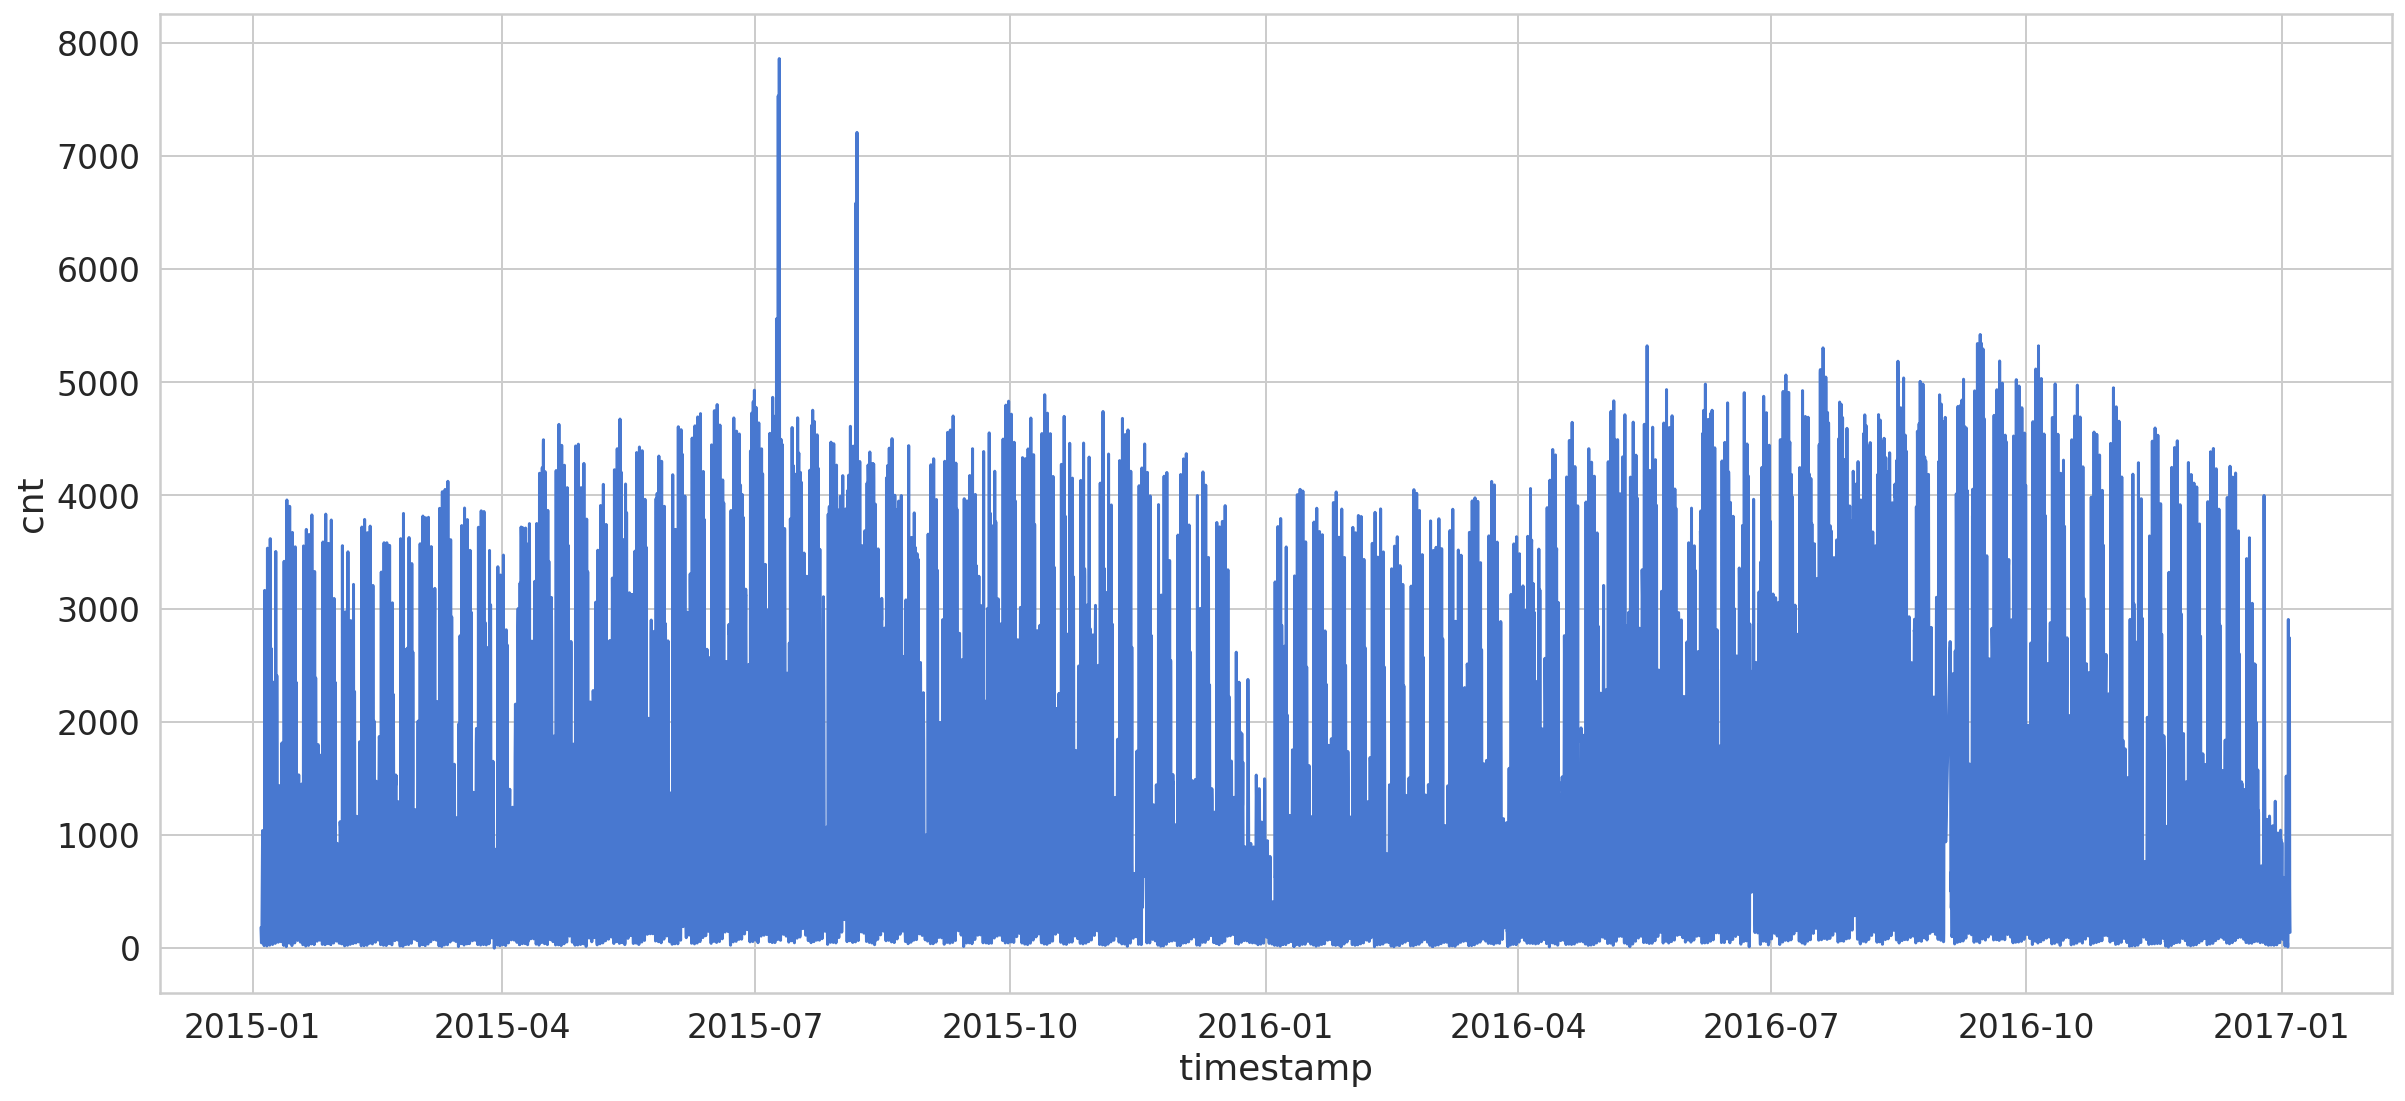

In [ ]:
sns.lineplot(x=df_pbs.index, y="cnt", data=df_pbs);

The data is crowded. The grpah would be clear if it's plotted on monthly basis

### Monthly Basis

#### Seasonal Changes (2015-01-31 to 2017-01-31)

In [ ]:
df_pbs.resample('M').sum()

cnt            t1            t2  ...  is_holiday  is_weekend  season
timestamp                                        ...                                
2015-01-31   546639   4101.000000   2255.500000  ...         0.0       192.0  2013.0
2015-02-28   543594   3721.500000   1868.000000  ...         0.0       192.0  2013.0
2015-03-31   695934   6093.500000   4558.500000  ...         0.0       215.0     0.0
2015-04-30   831582   7873.000000   7112.500000  ...        48.0       191.0     0.0
2015-05-31   895413  10091.500000   9803.500000  ...        48.0       240.0     0.0
2015-06-30  1033252  12151.500000  12073.000000  ...         0.0       192.0   717.0
2015-07-31  1120687  14107.000000  14060.000000  ...         0.0       192.0   740.0
2015-08-31  1033951  13830.500000  13816.500000  ...        24.0       240.0   744.0
2015-09-30   892478  10371.000000  10357.500000  ...         0.0       185.0  1422.0
2015-10-31   865046   9474.000000   9321.500000  ...         0.0       215.0  1472.0
2015-11-30   677332   8259.500000   7605.000000  ...         0.0       216.0  1422.0
2015-12-31   602838   9000.500000   8660.000000  ...        48.0       188.0  2220.0
2016-01-31   582518   5459.500000   3872.000000  ...        24.0       240.0  2232.0
2016-02-29   592910   4695.500000   3033.000000  ...         0.0       190.0  2064.0
2016-03-31   656527   5344.000000   3684.500000  ...        48.0       177.0     0.0
2016-04-30   768845   6804.500000   5708.500000  ...         0.0       216.0     0.0
2016-05-31  1001935  10663.000000  10537.500000  ...        48.0       216.0     0.0
2016-06-30   933878  11602.500000  11578.500000  ...         0.0       192.0   705.0
2016-07-31  1165527  14467.000000  14453.500000  ...         0.0       239.0   741.0
2016-08-31  1137314  14699.000000  14686.500000  ...        24.0       192.0   740.0
2016-09-30   998619  12813.000000  12800.000000  ...         0.0       180.0  1366.0
2016-10-31   935706   9363.333333   9239.833333  ...         0.0       239.0  1486.0
2016-11-30   703859   5827.000000   4499.500000  ...         0.0       191.0  1438.0
2016-12-31   651908   5967.500000   4925.000000  ...        48.0       216.0  2232.0
2017-01-31    37680    339.000000    114.000000  ...        24.0        24.0   216.0

[25 rows x 9 columns]

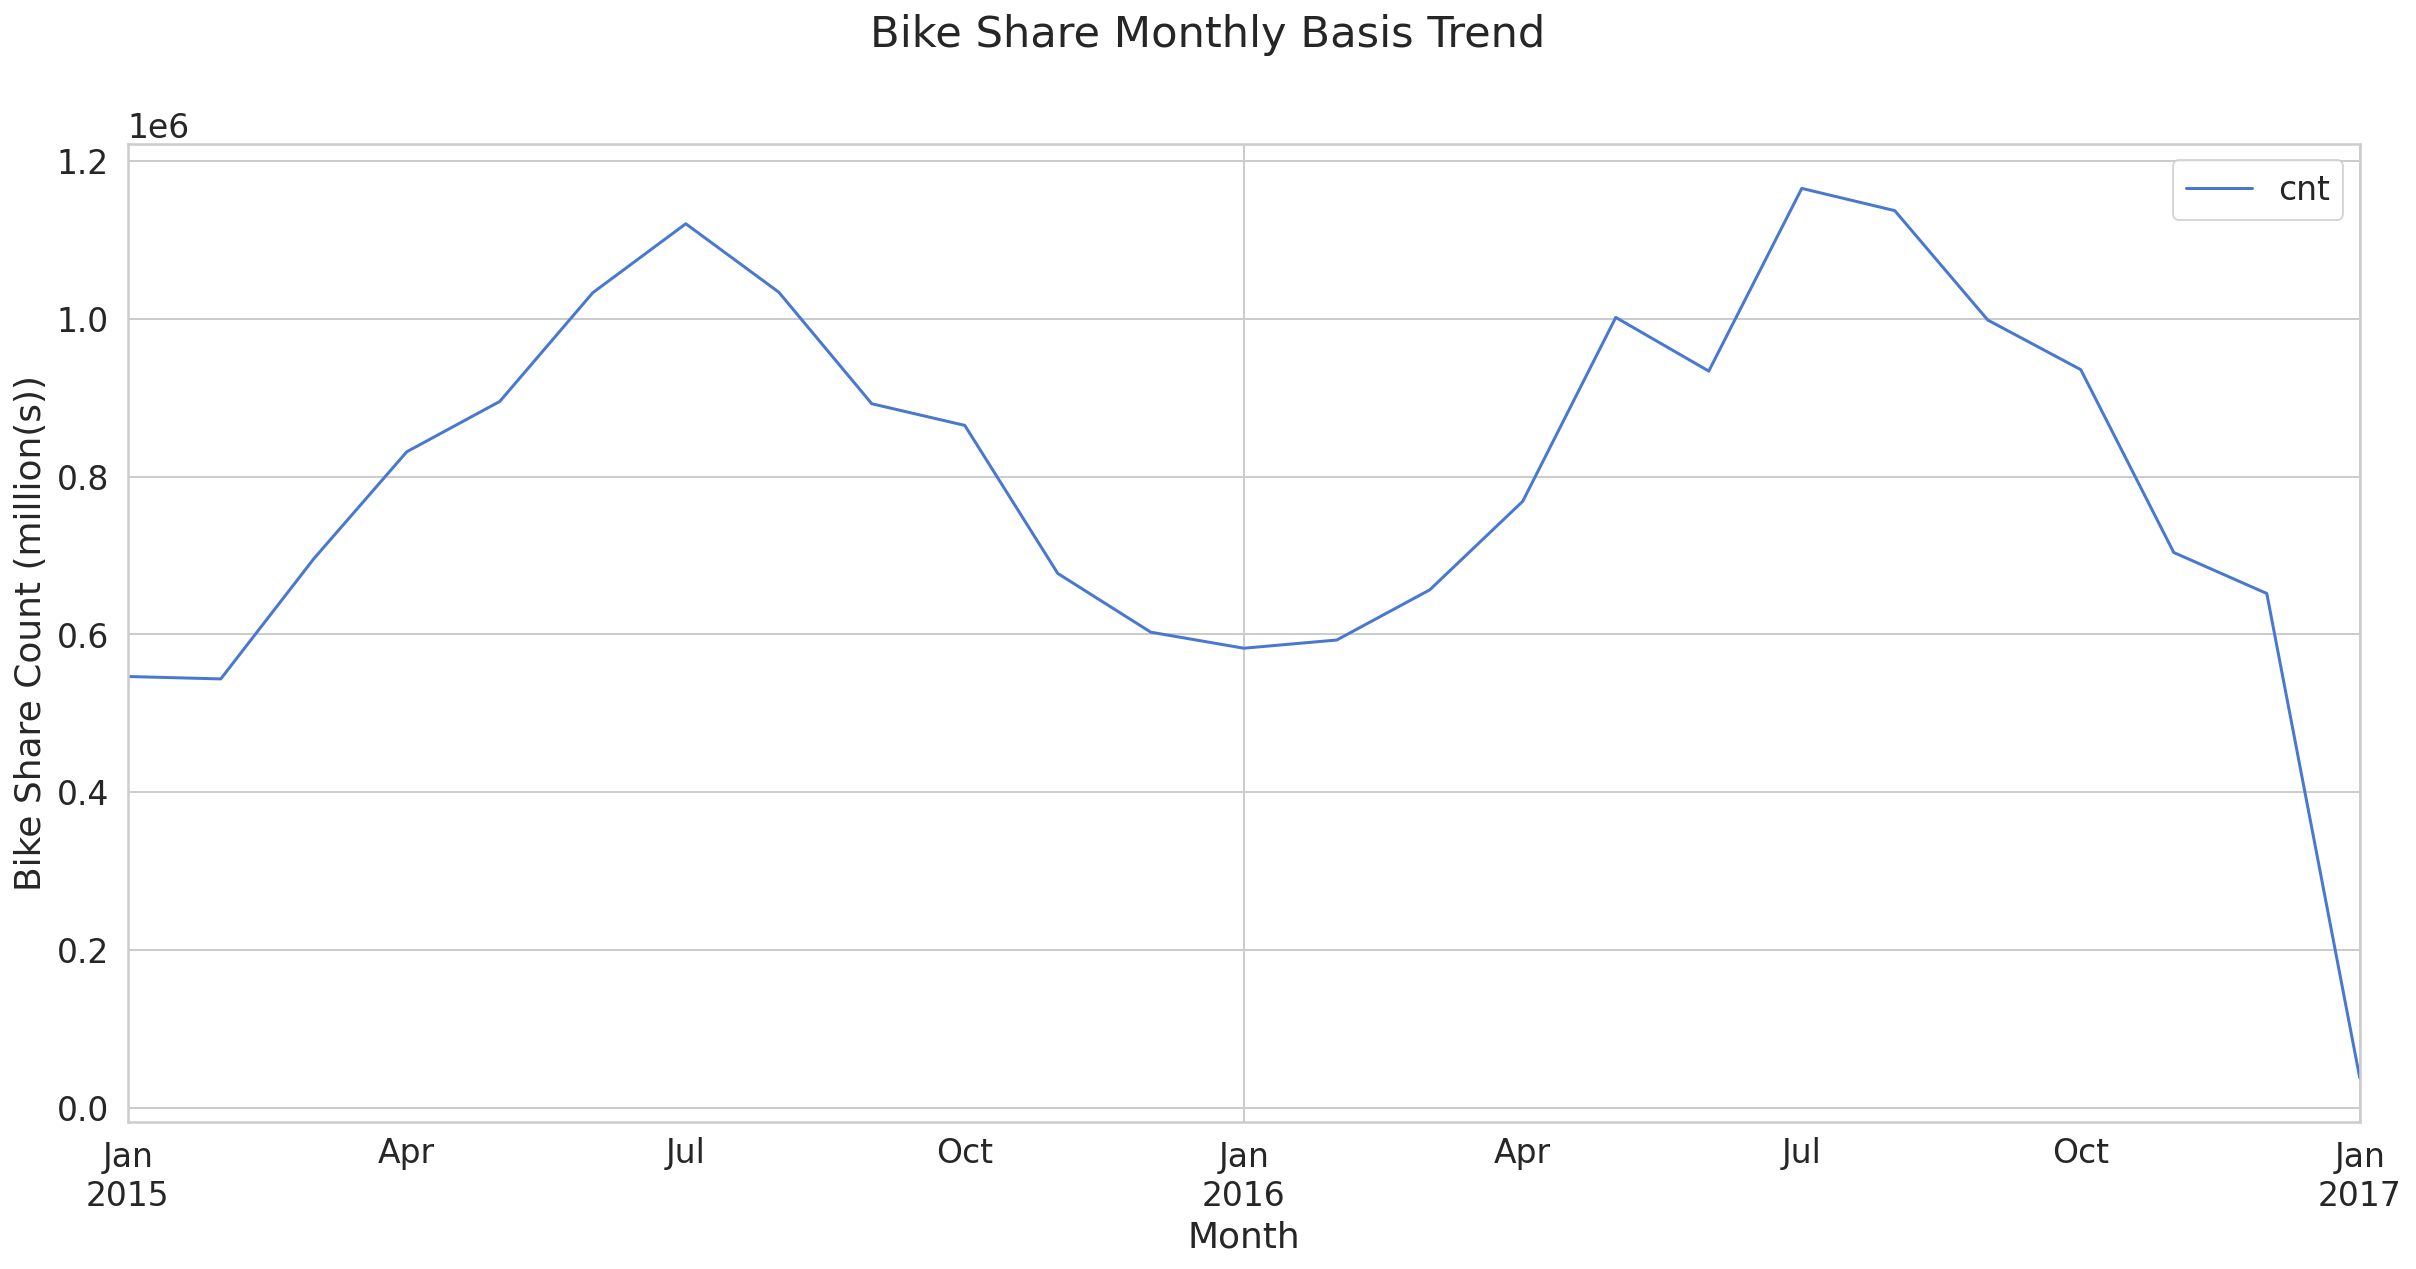

In [ ]:
df_pbs.resample('M').sum().plot(y='cnt');
plt.xlabel('Month')
plt.ylabel('Bike Share Count (million(s))')
plt.suptitle('Bike Share Monthly Basis Trend')
plt.show();

# df_pbs_month = df_pbs.resample('M').sum()
# sns.lineplot(x=df_pbs_month.index, y='cnt', data=df_pbs_month);

From the graph above it is clear that it has a strong seasonality component. **Summer months are good for bike share business**

## Autocorrelation 

We can quantify the strength and type of relationship between observations and their lags. In statistics, this is called correlation, and when calculated against lag values in time series, it is called **autocorrelation** (self-correlation)

A correlation value calculated between two groups of numbers, such as observations and their lag1 values, results in a number between -1 and 1. The sign of this number indicates a negative or positive correlation respectively. **A value close to zero suggests a weak correlation, whereas a value closer to -1 or 1 indicates a strong correlation**

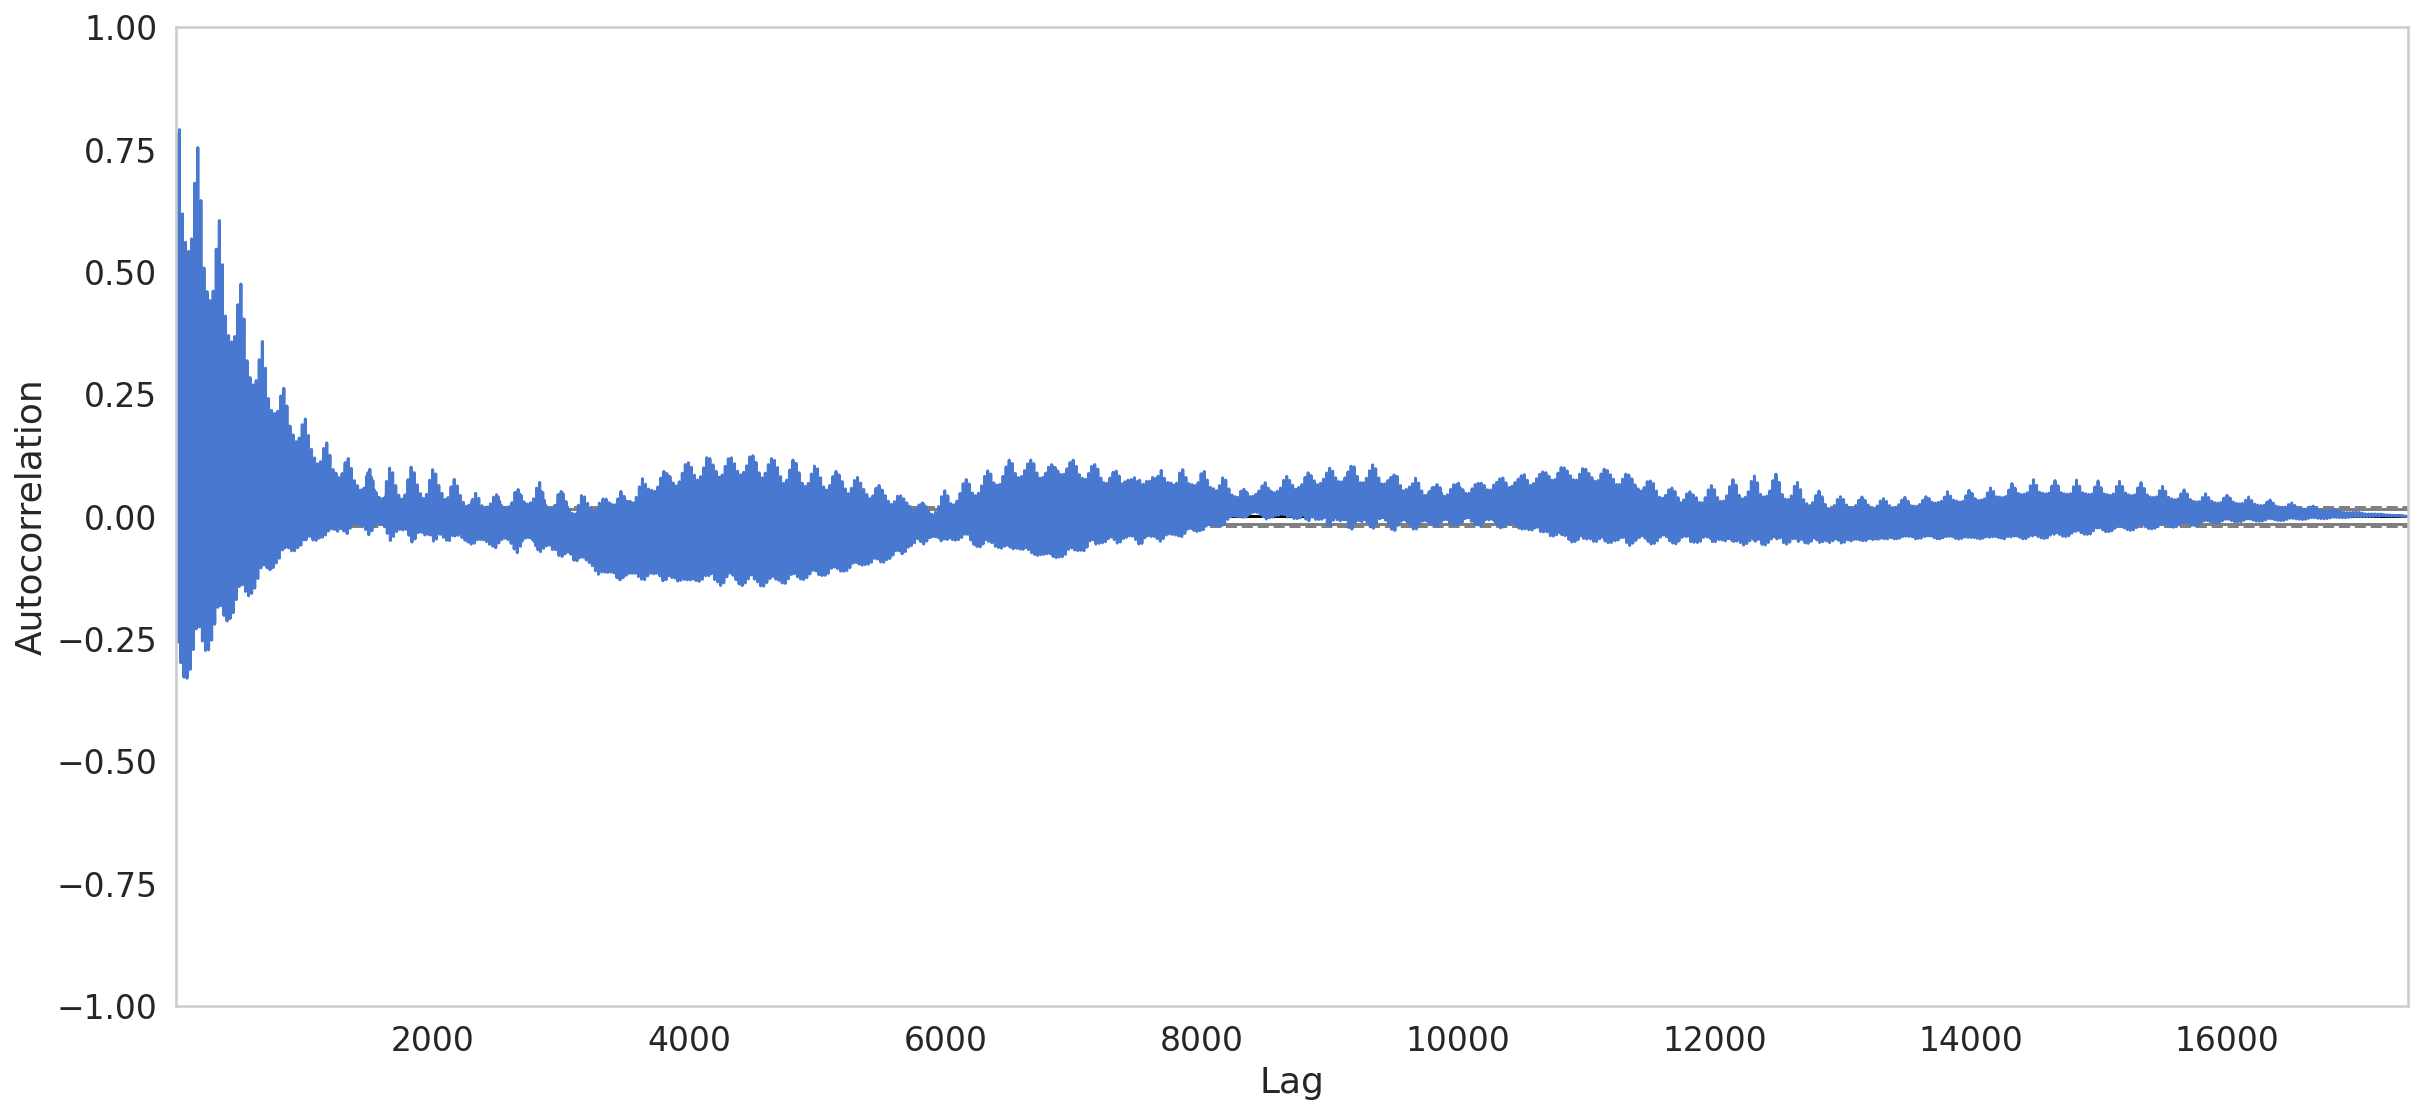

In [ ]:
pd.plotting.autocorrelation_plot(df_pbs.cnt);

### Monthly Basis

If month is considered as the lag unit then, there can be seen cycles of strong negative and positive correlation

**correlation values above the dotted lines are statistically significant**

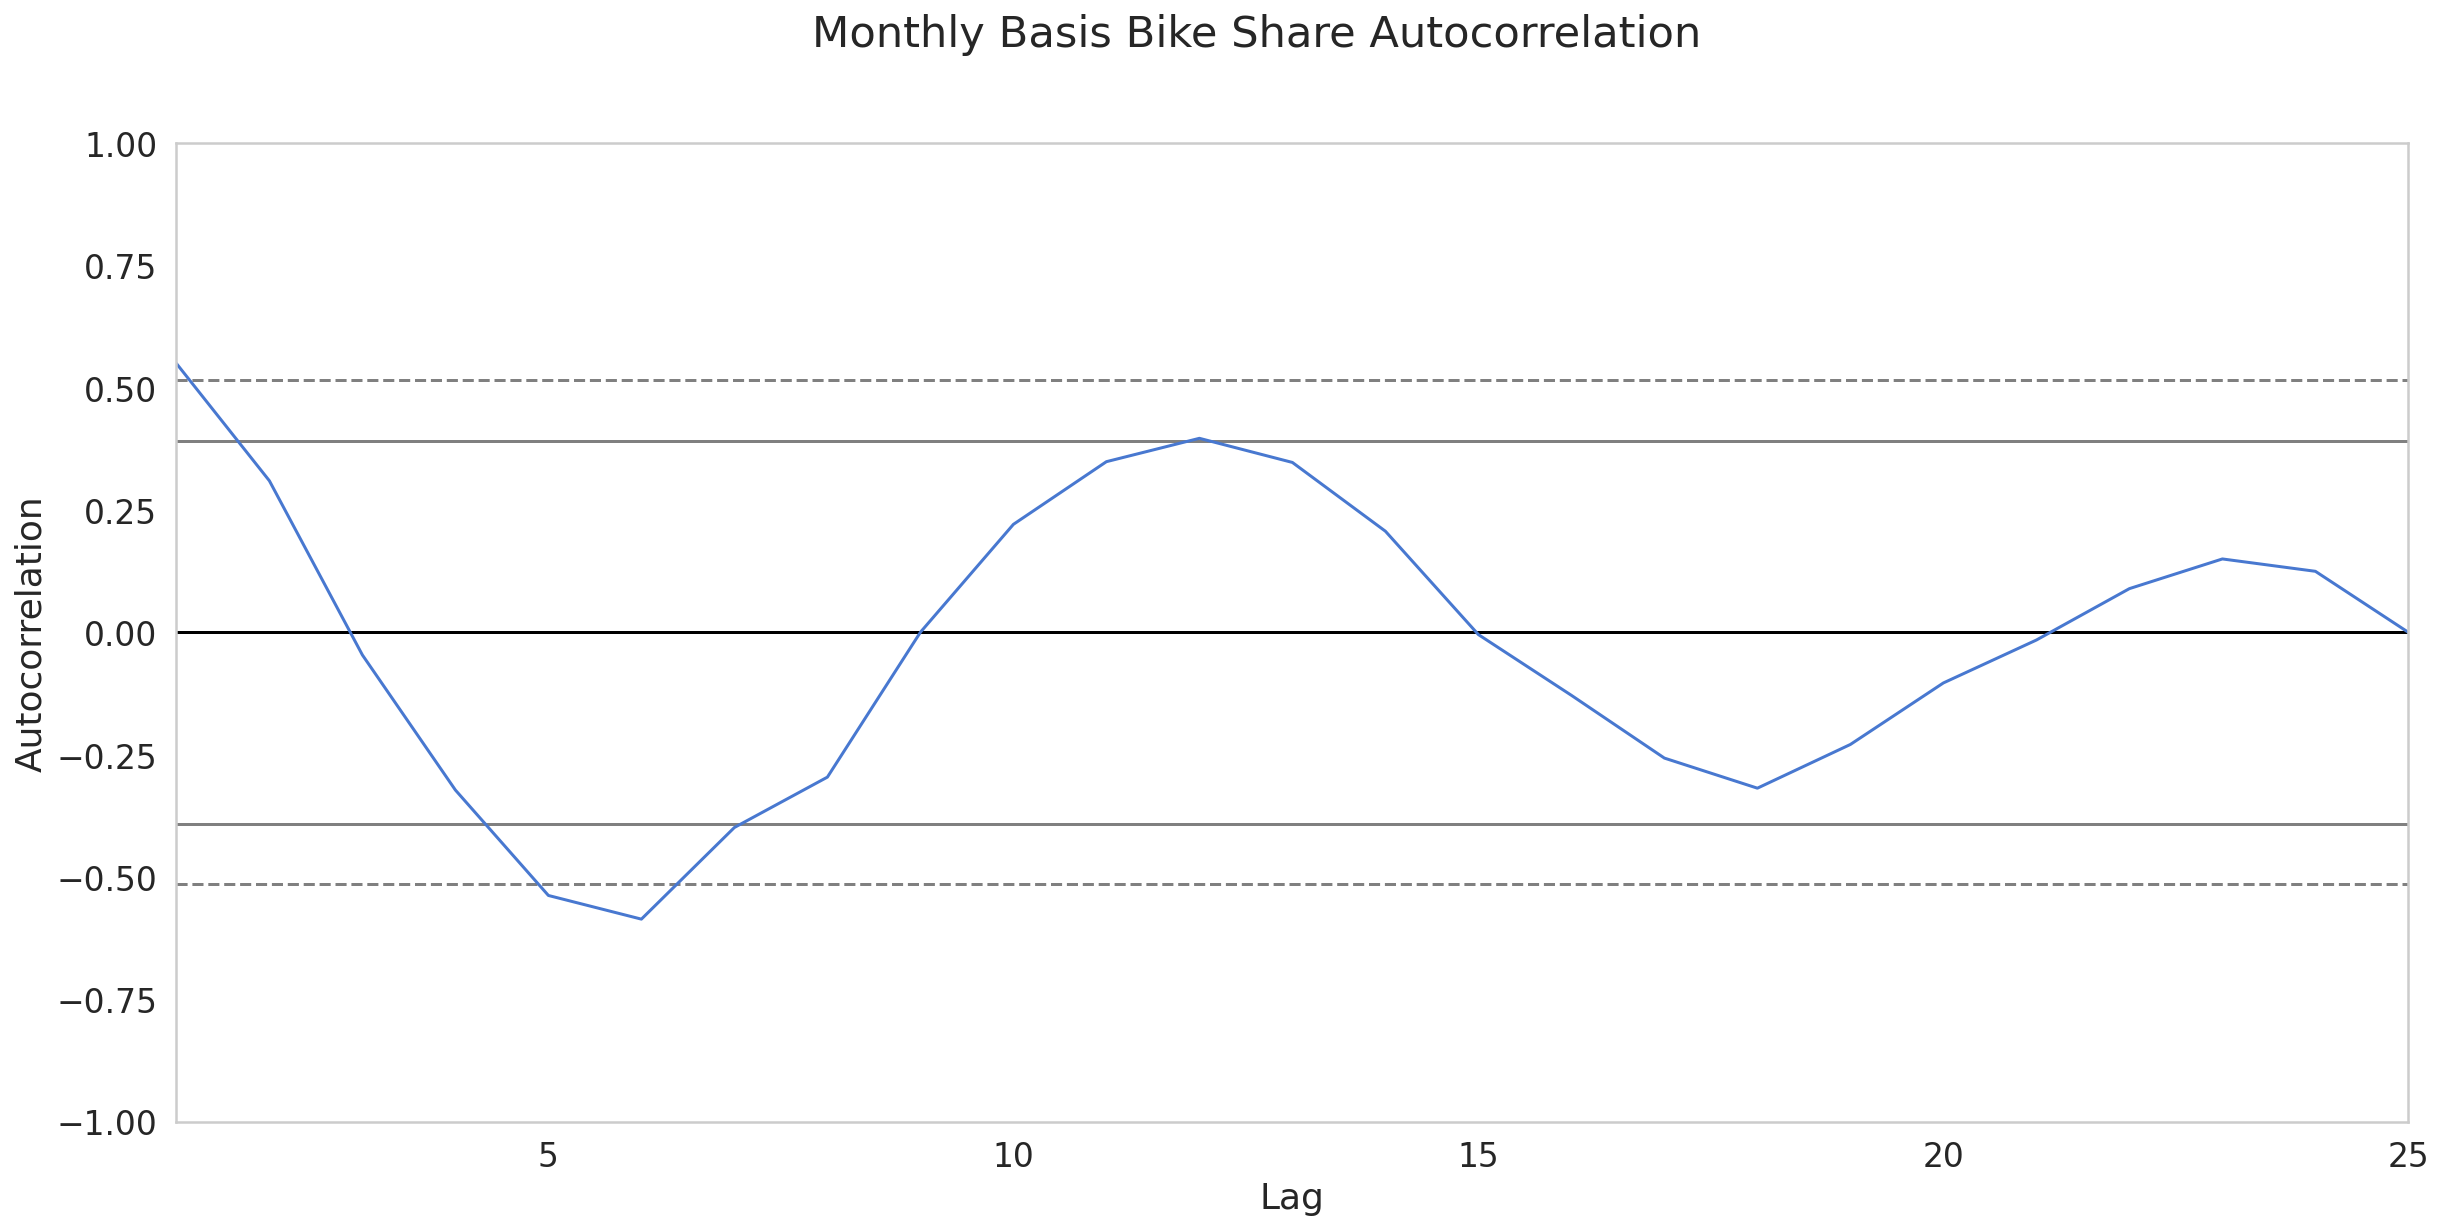

In [ ]:
pd.plotting.autocorrelation_plot(df_pbs.resample('M').sum().cnt)
plt.suptitle('Monthly Basis Bike Share Autocorrelation')
plt.show();

## Humidity Distribution

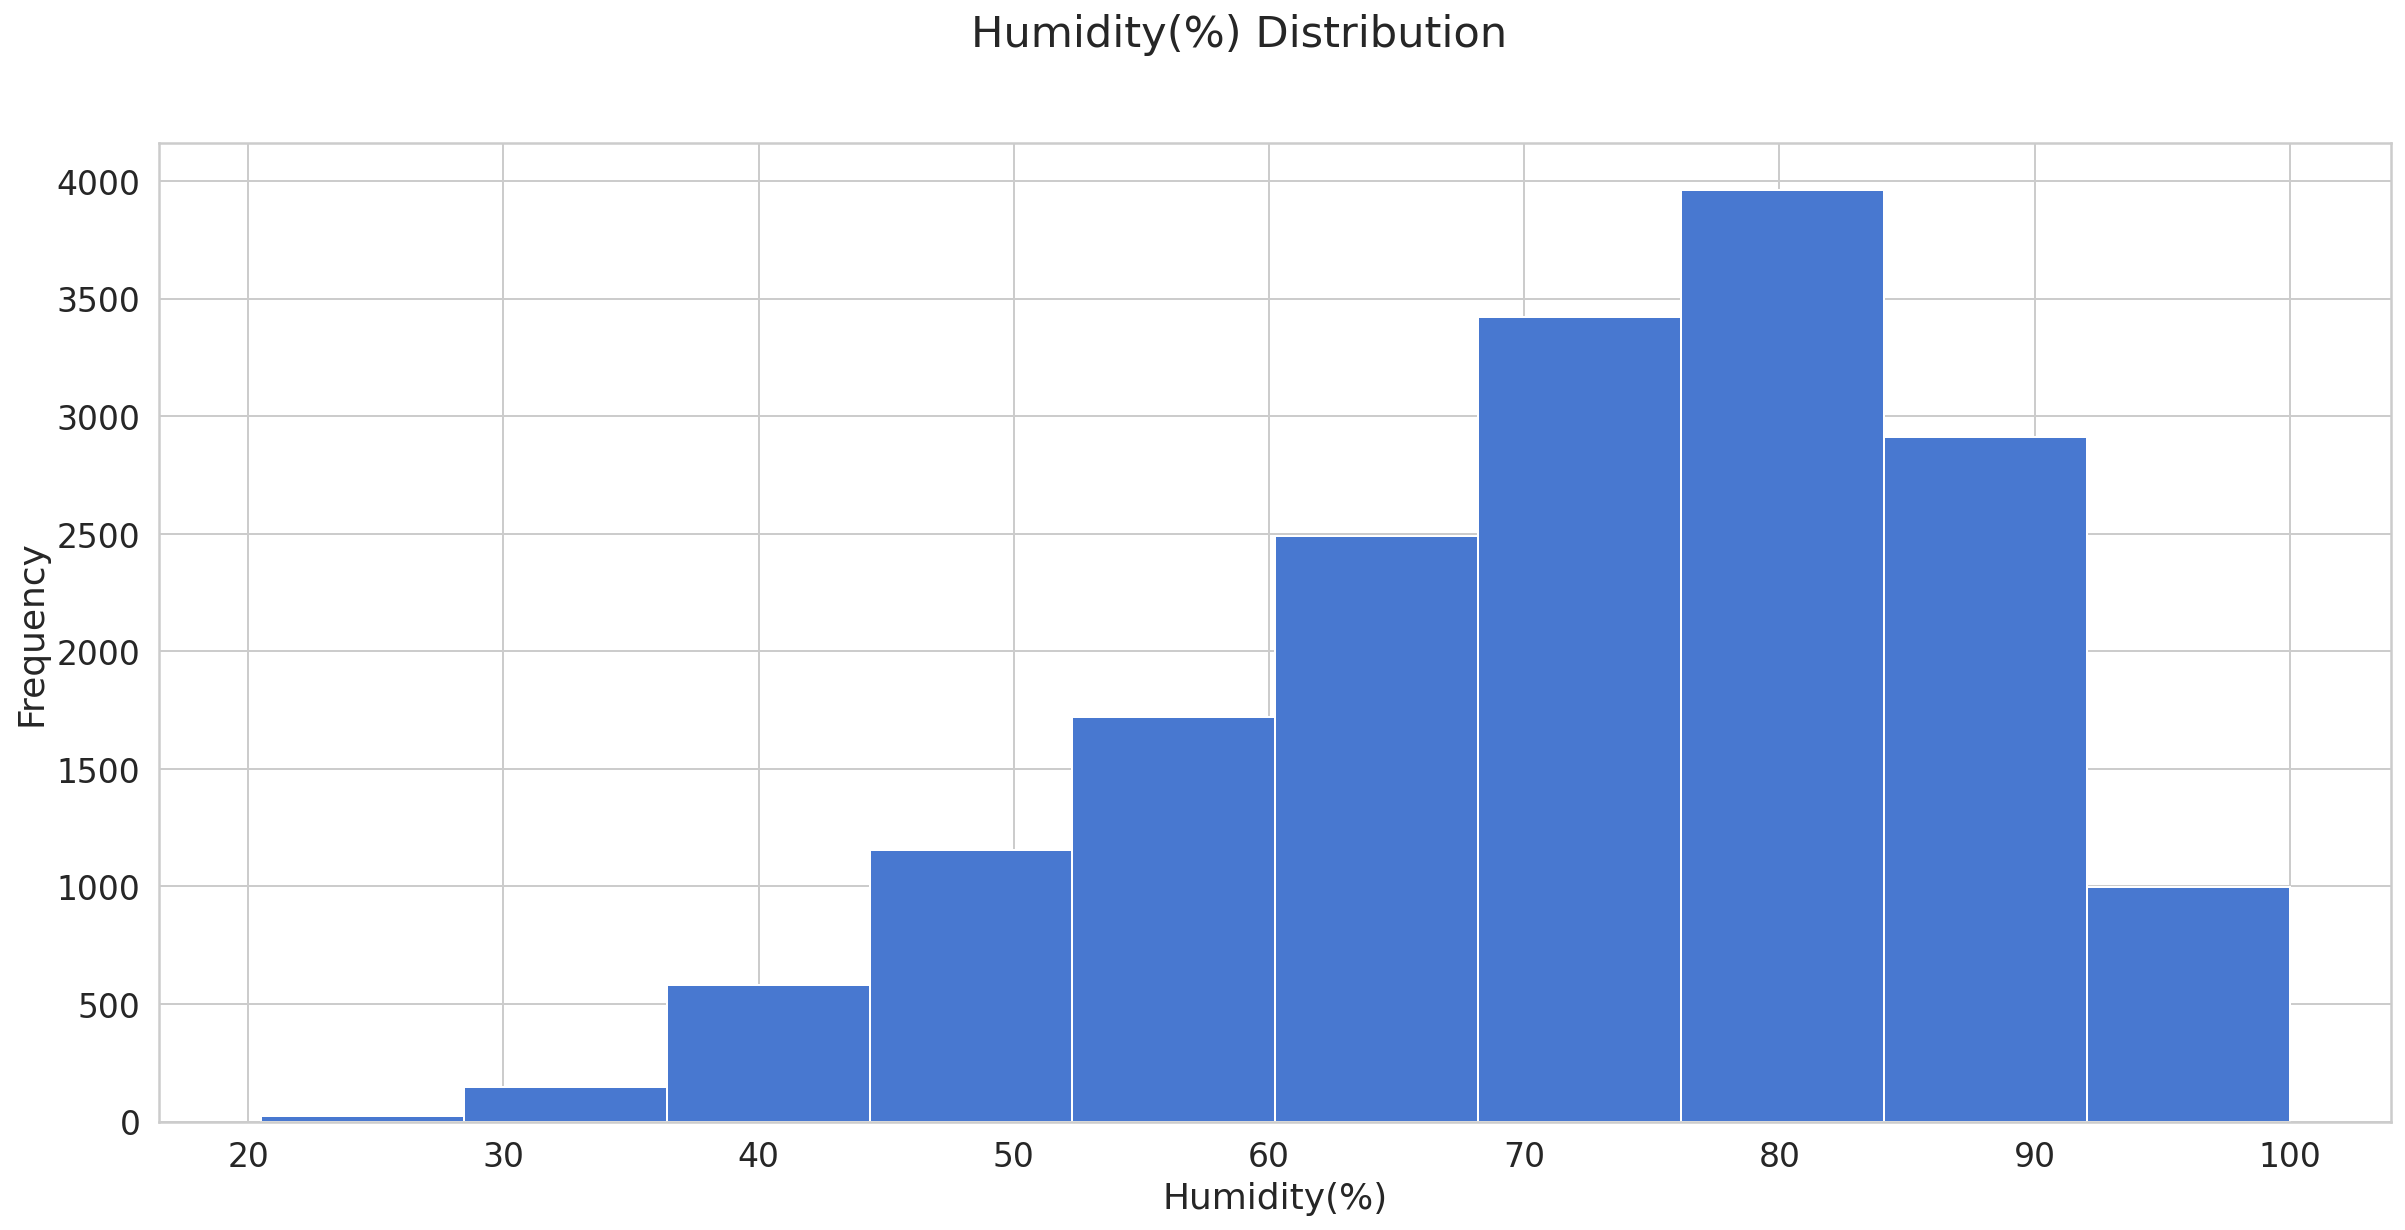

In [ ]:
df_pbs.hum.hist()
plt.xlabel('Humidity(%)')
plt.ylabel('Frequency')
plt.suptitle('Humidity(%) Distribution')
plt.show();

**The humidity mostly falls around 80%**

## Temperature Distribution

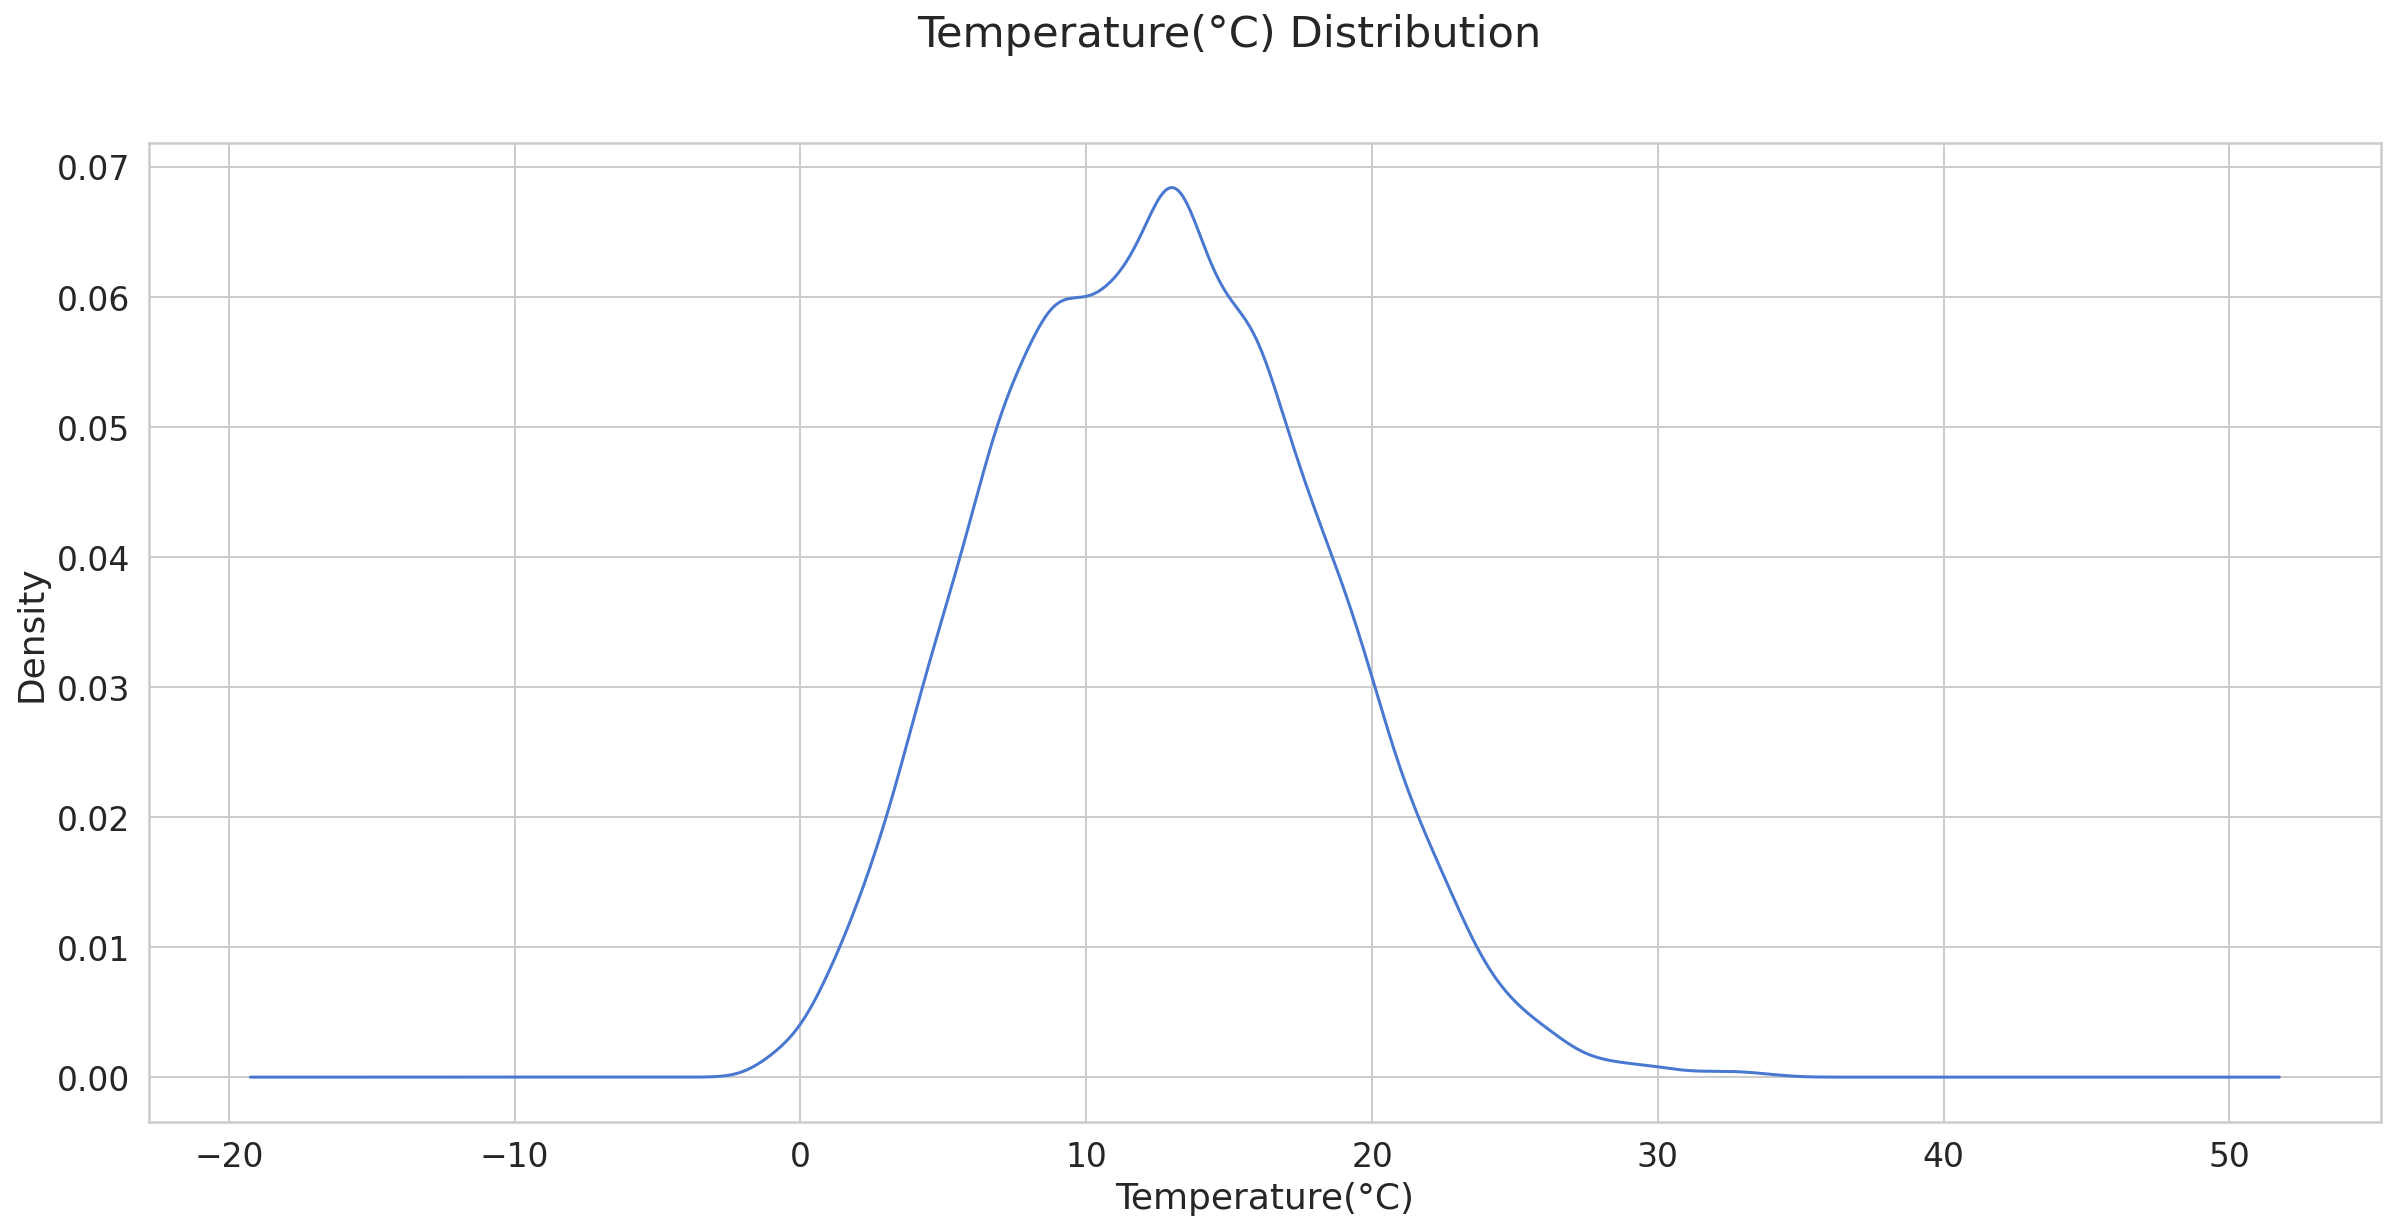

In [ ]:
# degree celcius
df_pbs.t1.plot(kind='kde');
plt.xlabel('Temperature(°C)')
plt.ylabel('Density')
plt.suptitle('Temperature(°C) Distribution')
plt.show();

Mostly around 10-18(°C) 

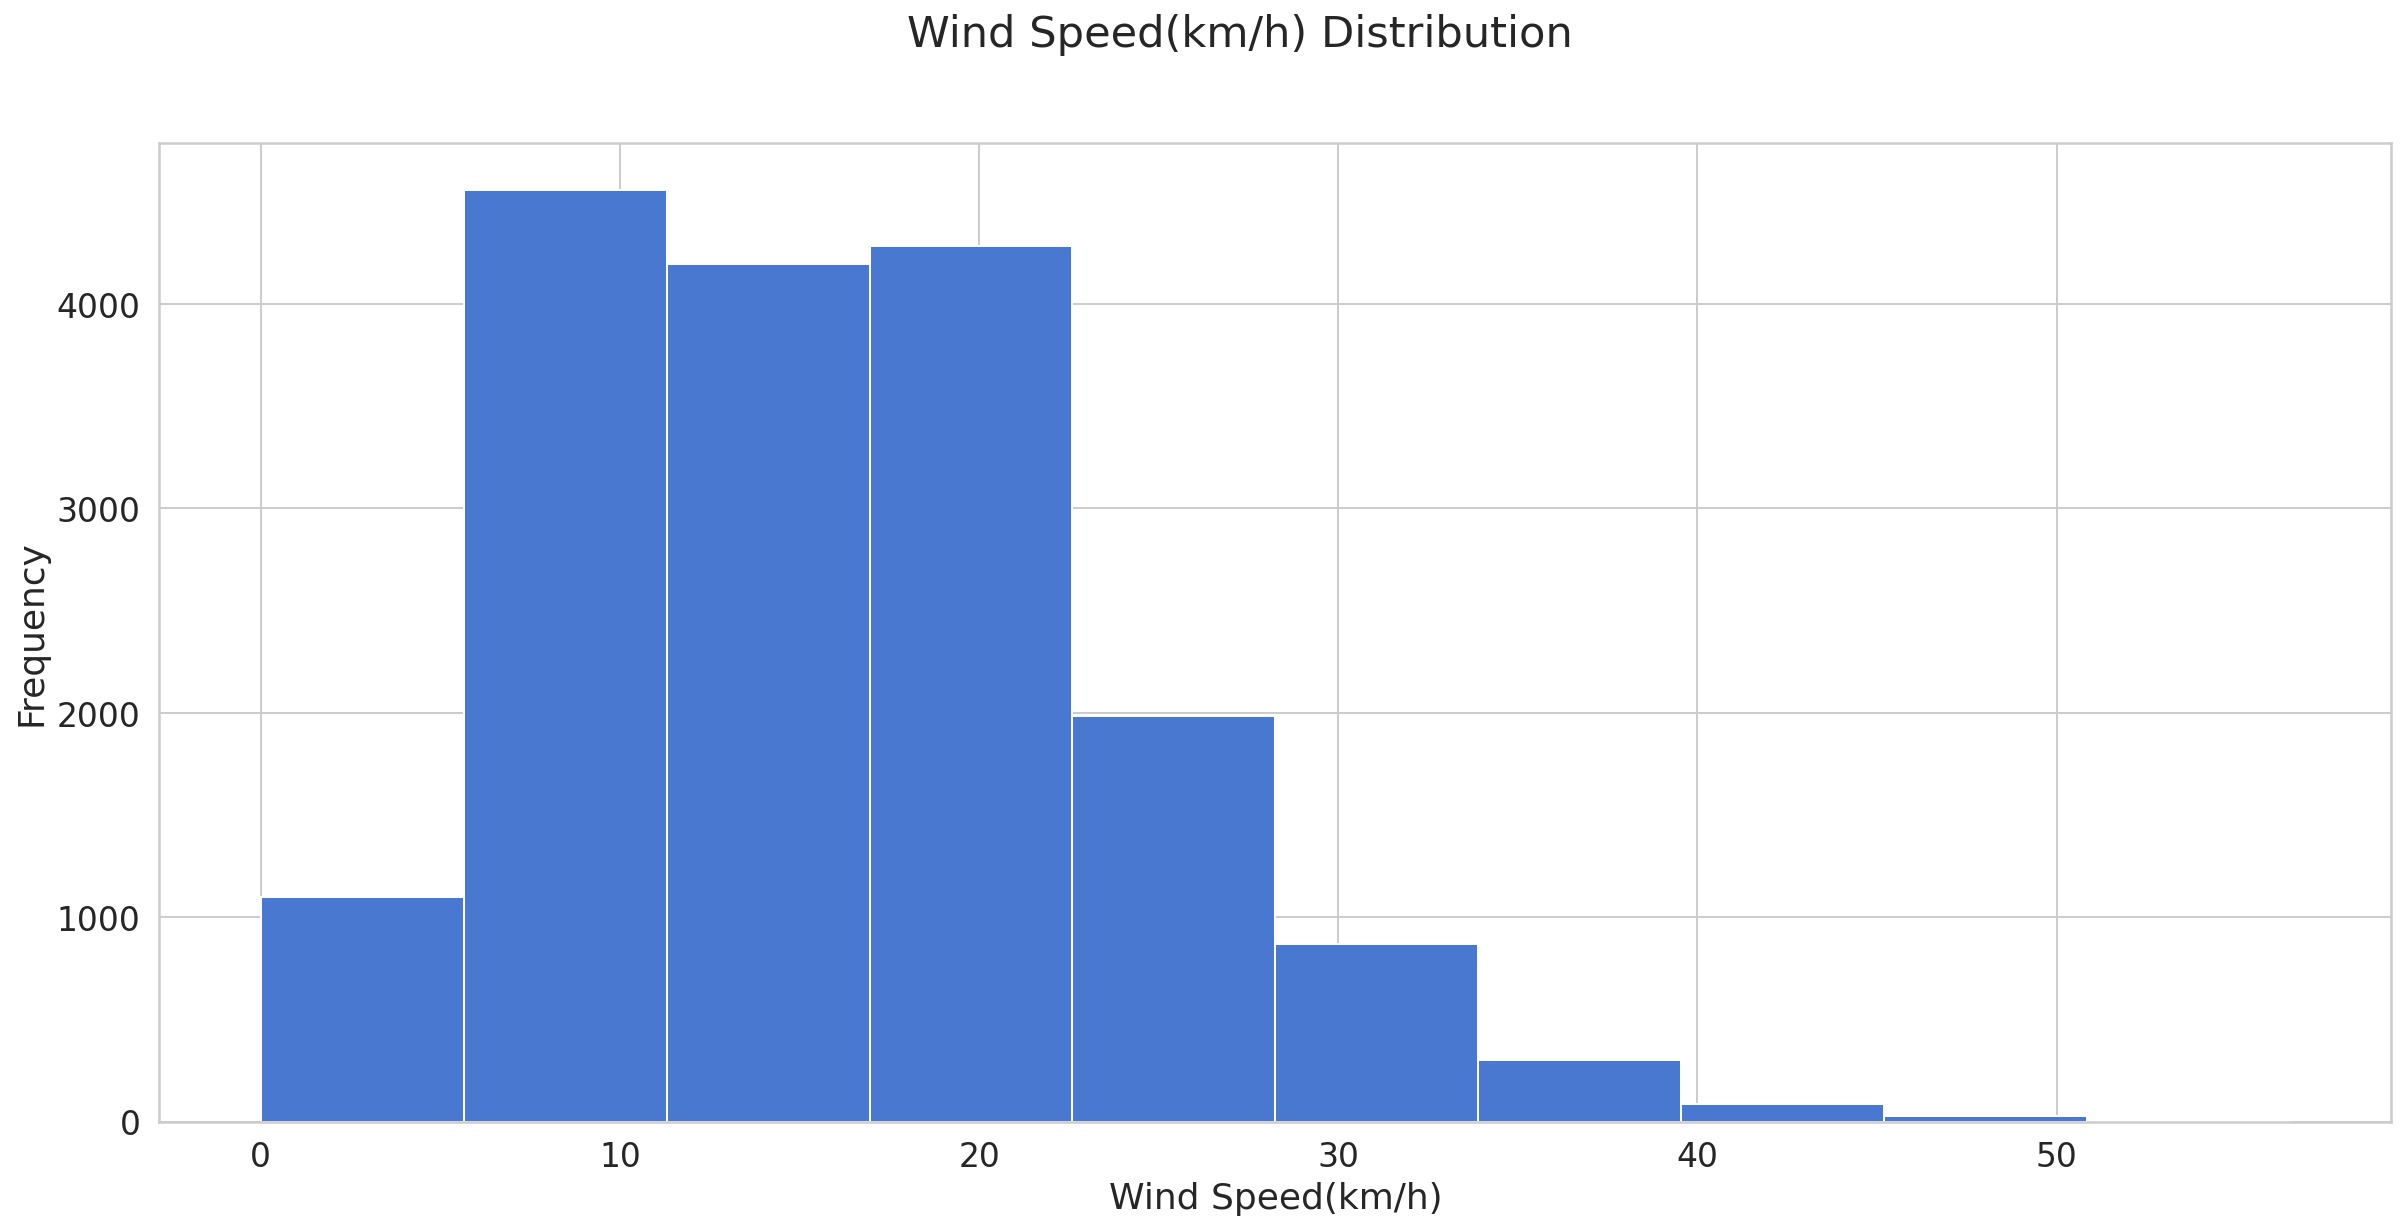

In [ ]:
df_pbs.wind_speed.hist()
plt.xlabel('Wind Speed(km/h)')
plt.ylabel('Frequency')
plt.suptitle('Wind Speed(km/h) Distribution')
plt.show();

**The wind speed mostly falls around 10-20 kmph**

## Bike Share Trend

### Hour Time

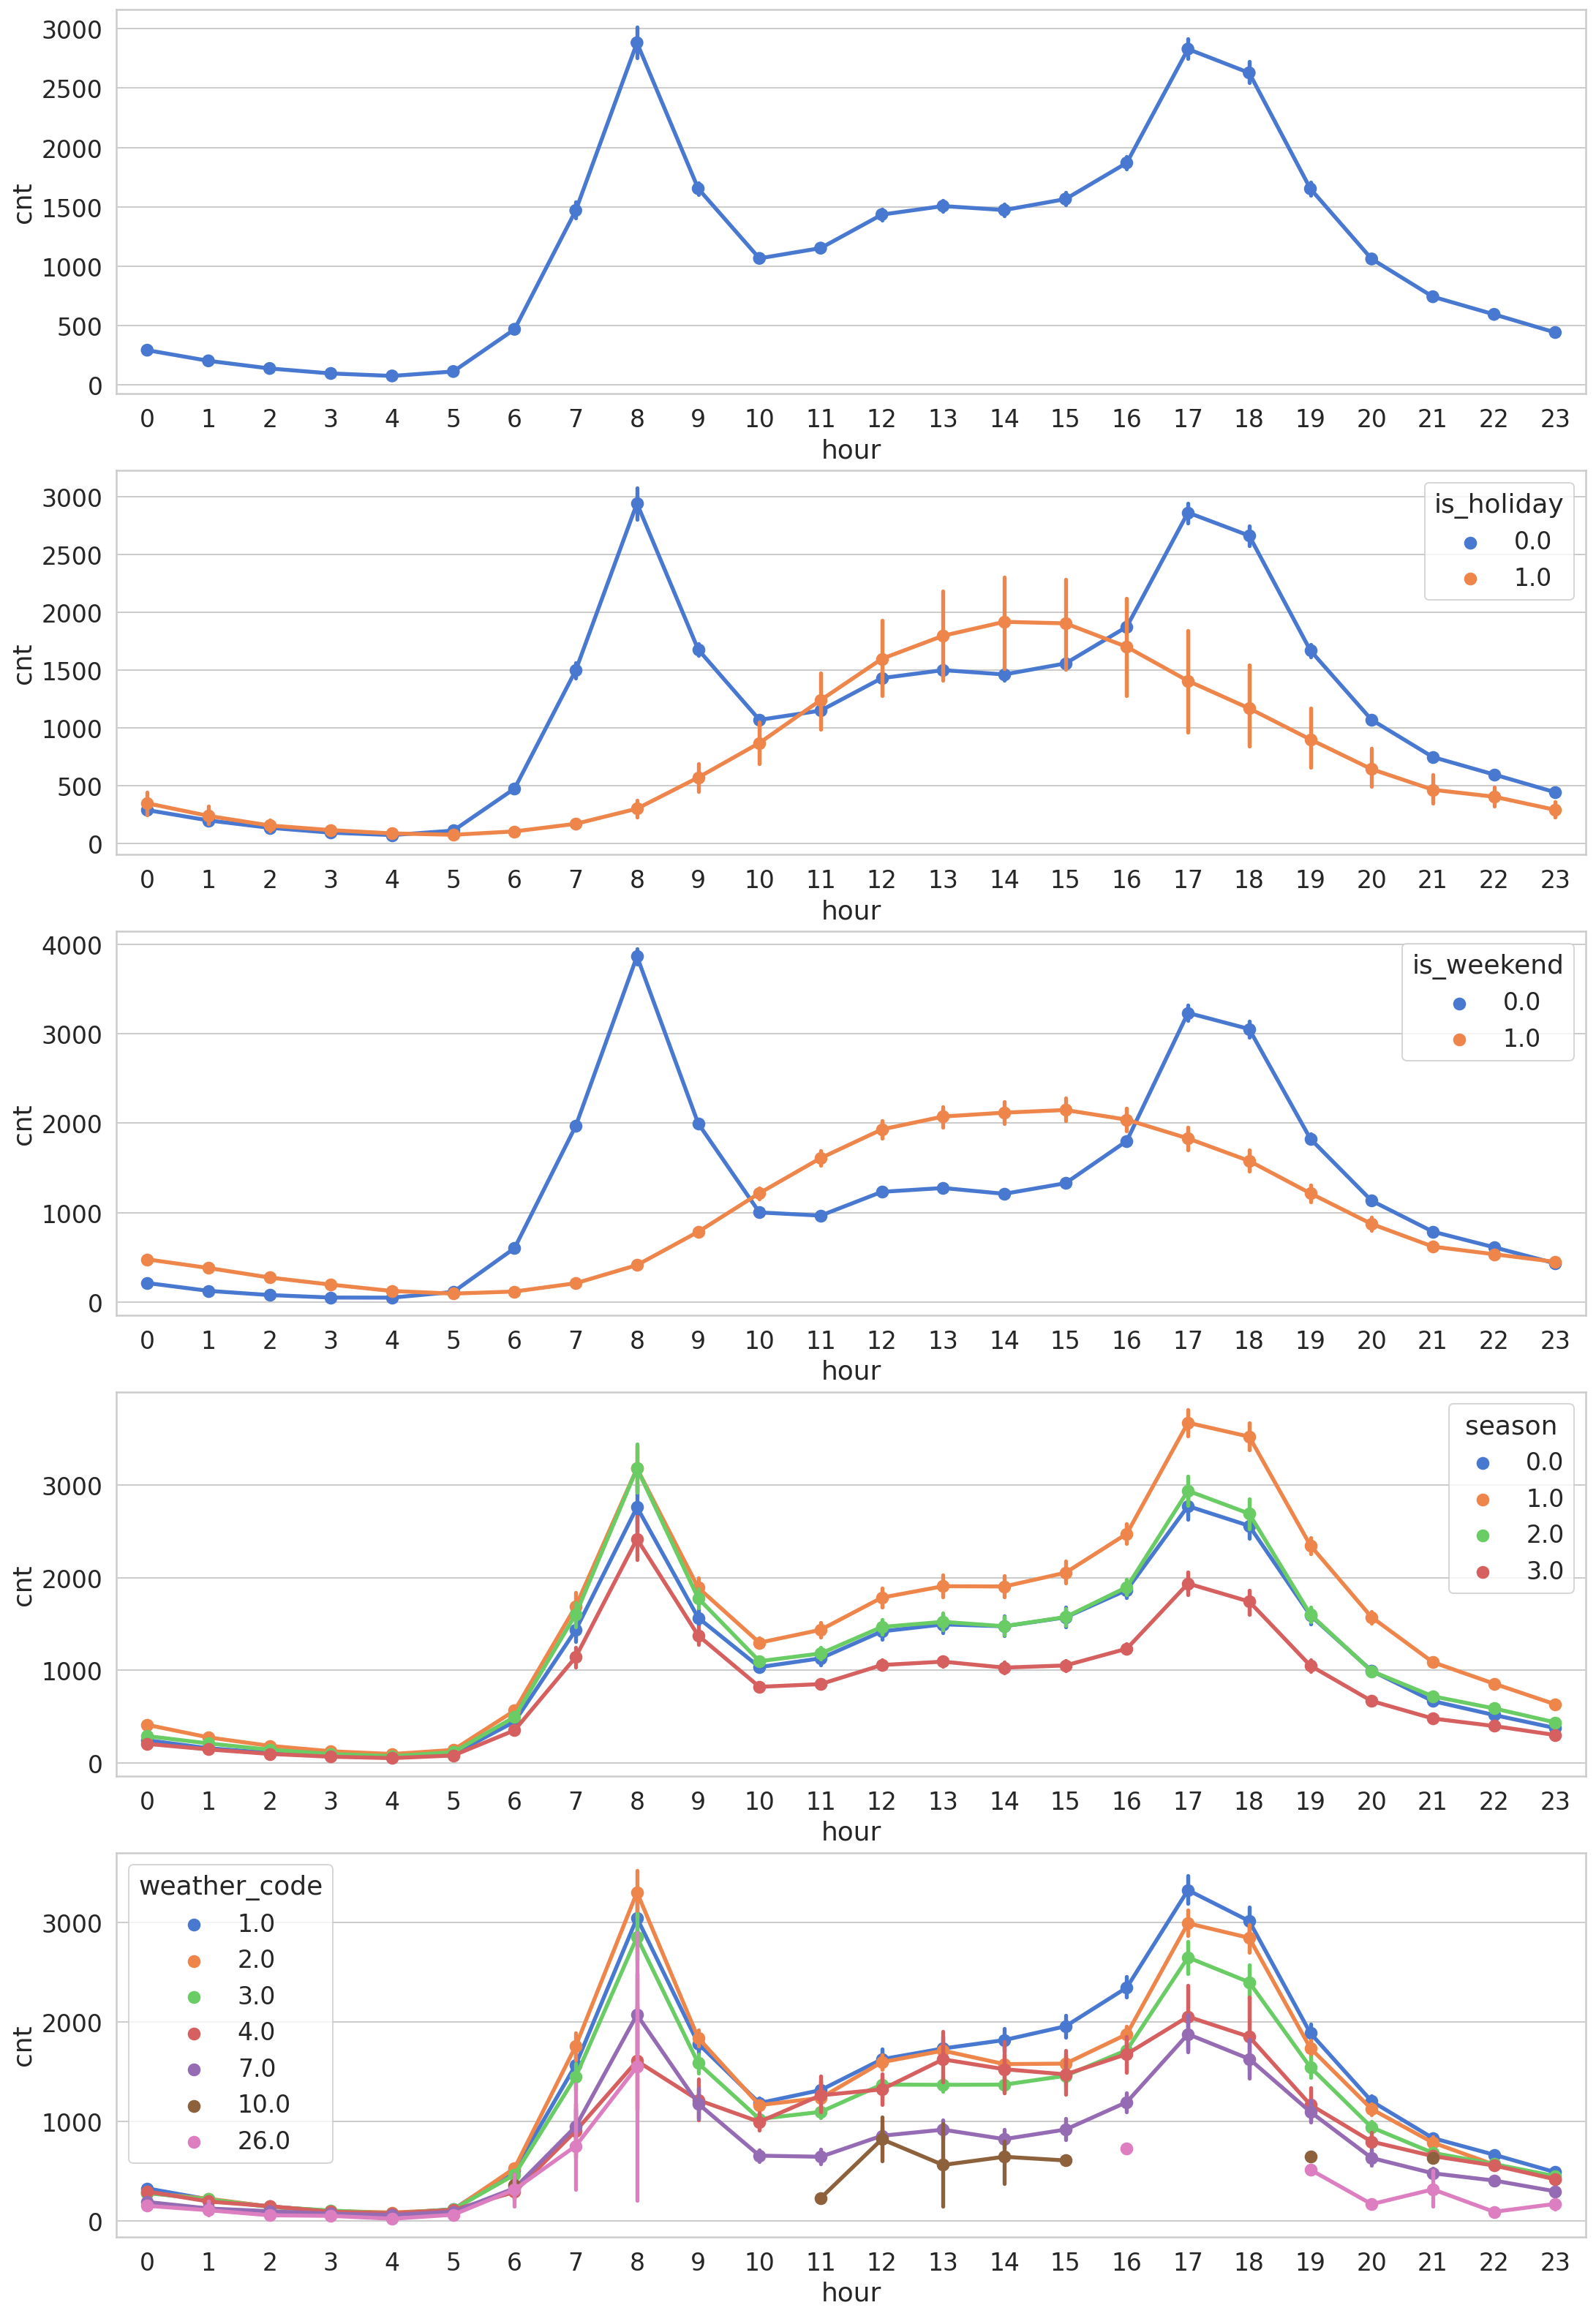

In [ ]:
fig,(ax1, ax2, ax3, ax4, ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18, 28)

sns.pointplot(data=df_pbs, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df_pbs, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df_pbs, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df_pbs, x='hour', y='cnt', hue='season', ax=ax4)
sns.pointplot(data=df_pbs, x='hour', y='cnt', hue='weather_code', ax=ax5);

**Bike Share Based on** 
1. Day Type - 
* The number of Bike shares differs a lot on an hourly basis based on the day type - workday or weekend or holiday.

* During the workday, people mostly use bike share bikes in two times - during the morning and late afternoon (work in between)

* On the other hand, on weekends (or holidays) early to late afternoon hours seem to be the busiest

2. Season Type -
* In terms of the ride-share summer season is the busiest, then fall, spring and winter

3. Weather condition -
* Bike share is higher when the sky is clear or has few clouds, it's lowest when there is rain with a thunderstorm or snowfall
* People don't prefer bike share when there is rain





### Day of Week

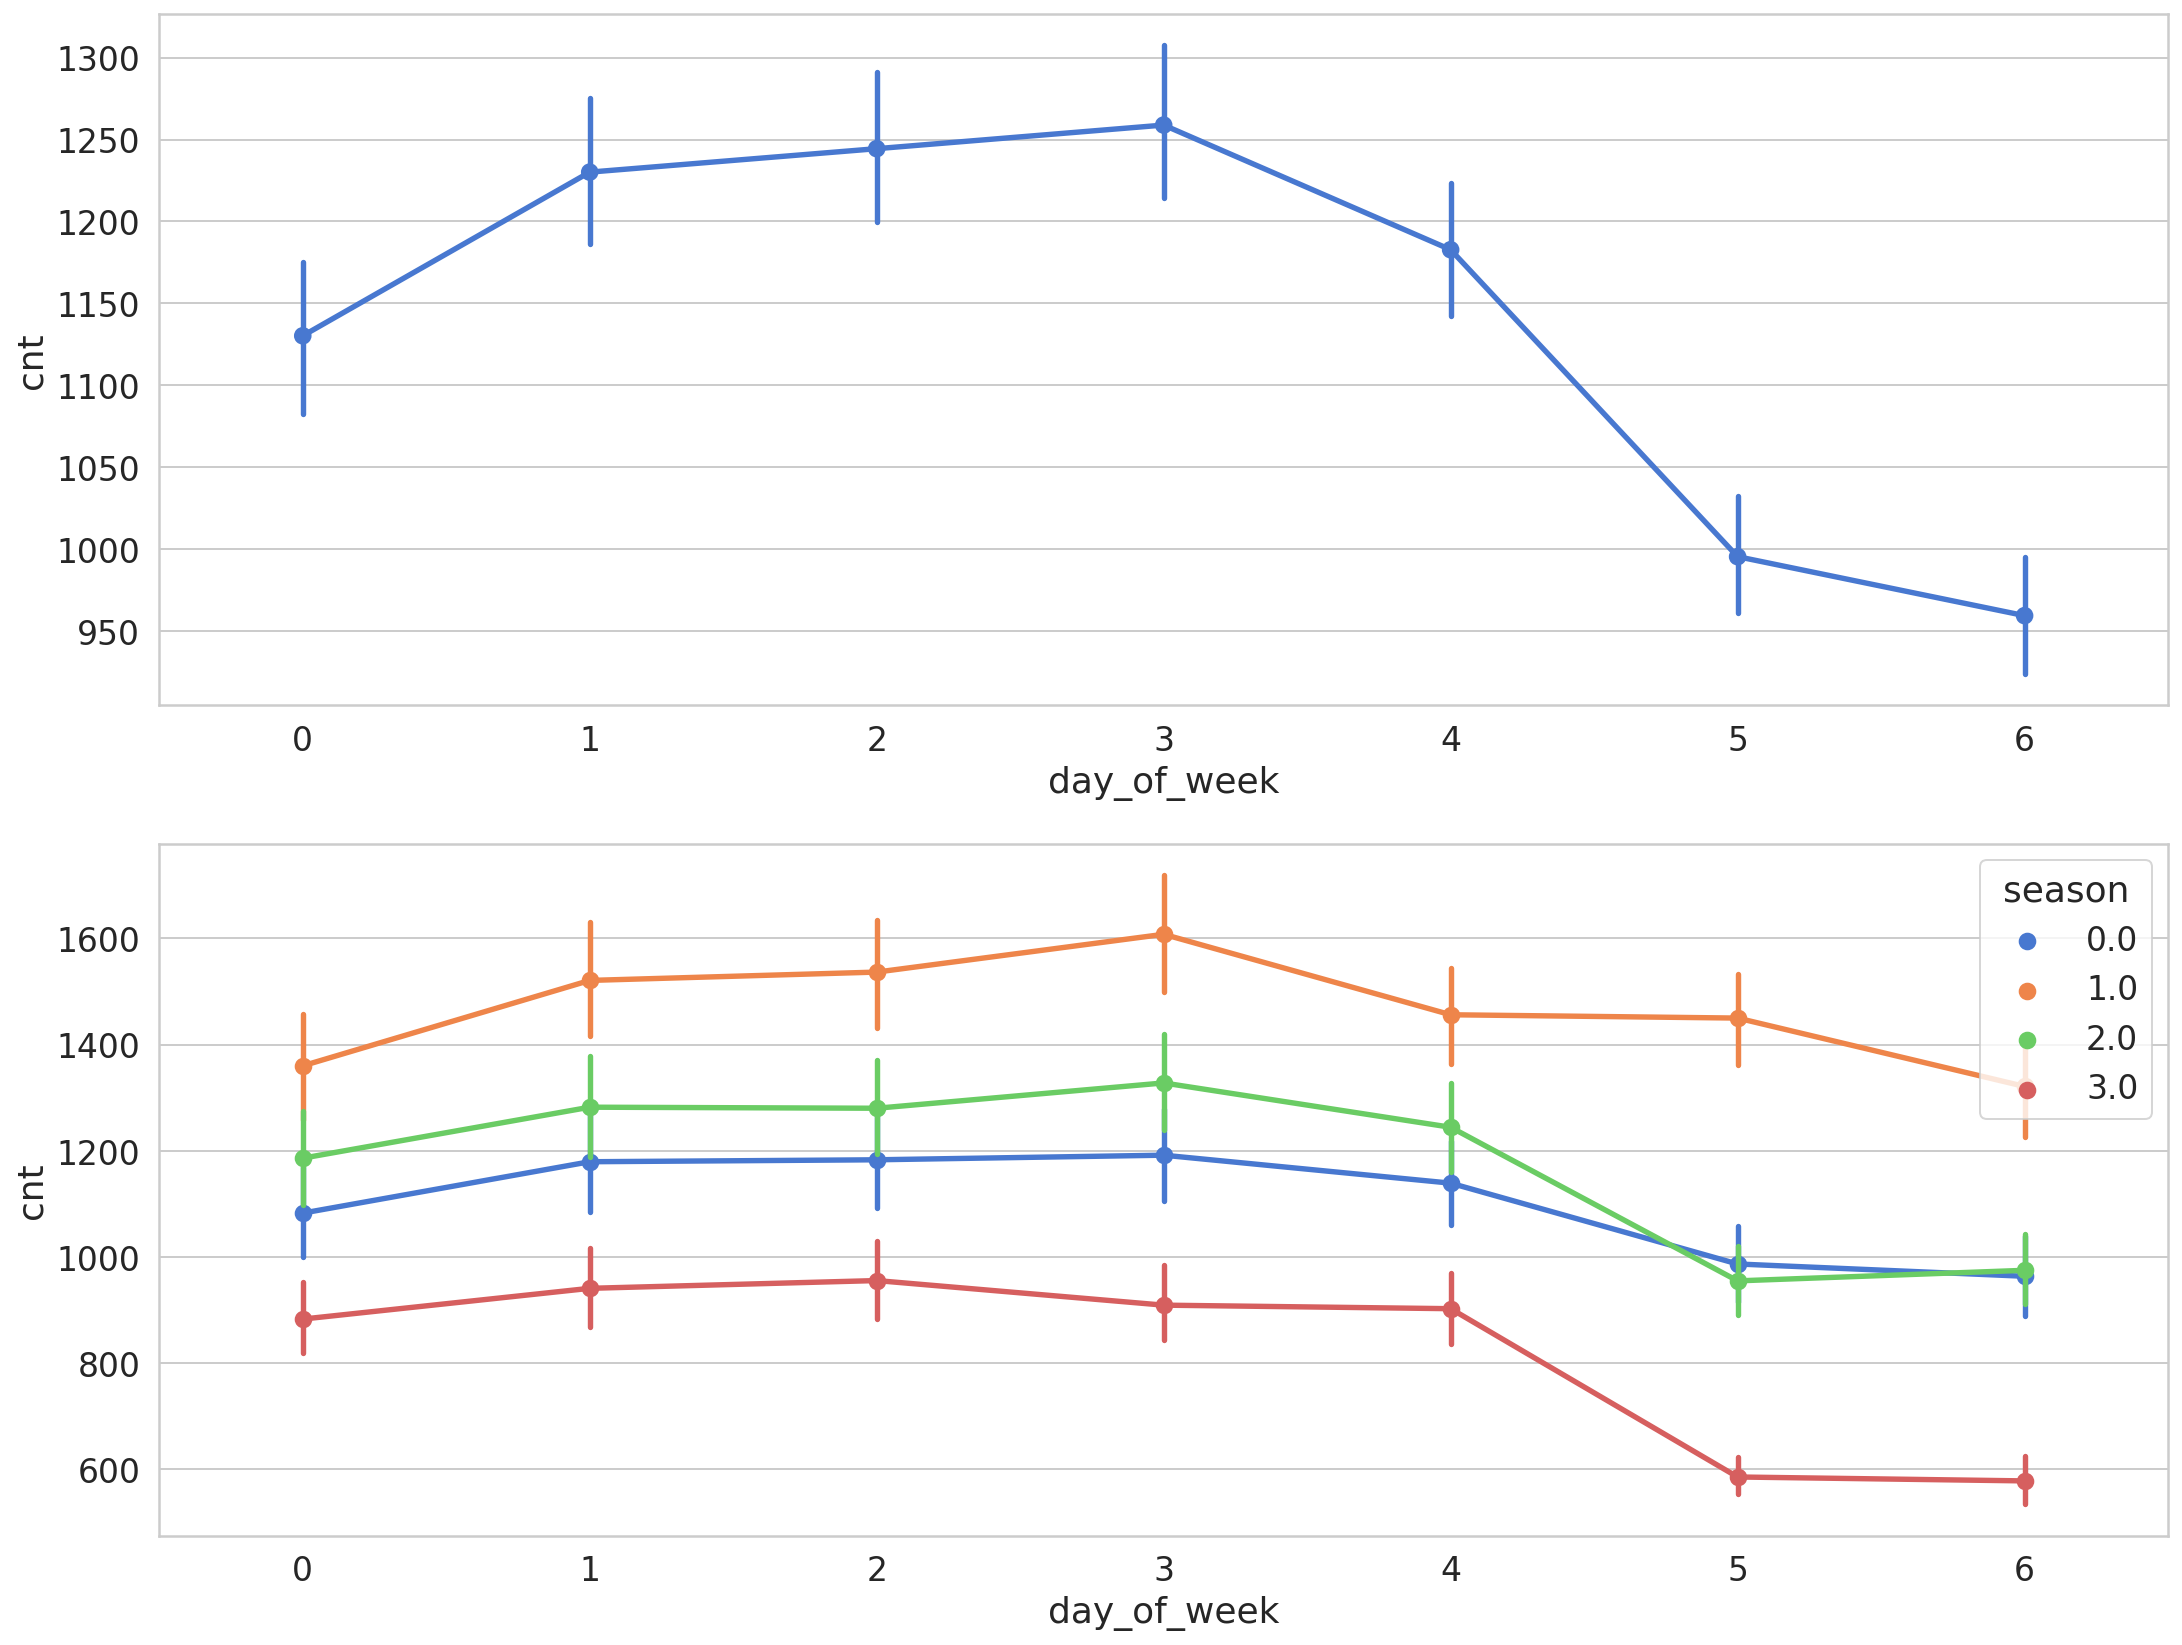

In [ ]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df_pbs, x='day_of_week', y='cnt', ax=ax1)
sns.pointplot(data=df_pbs, x='day_of_week', y='cnt', hue='season', ax=ax2);

**Number of bike share drops on weekends (Saturday and Sunday)**

### Day of Month

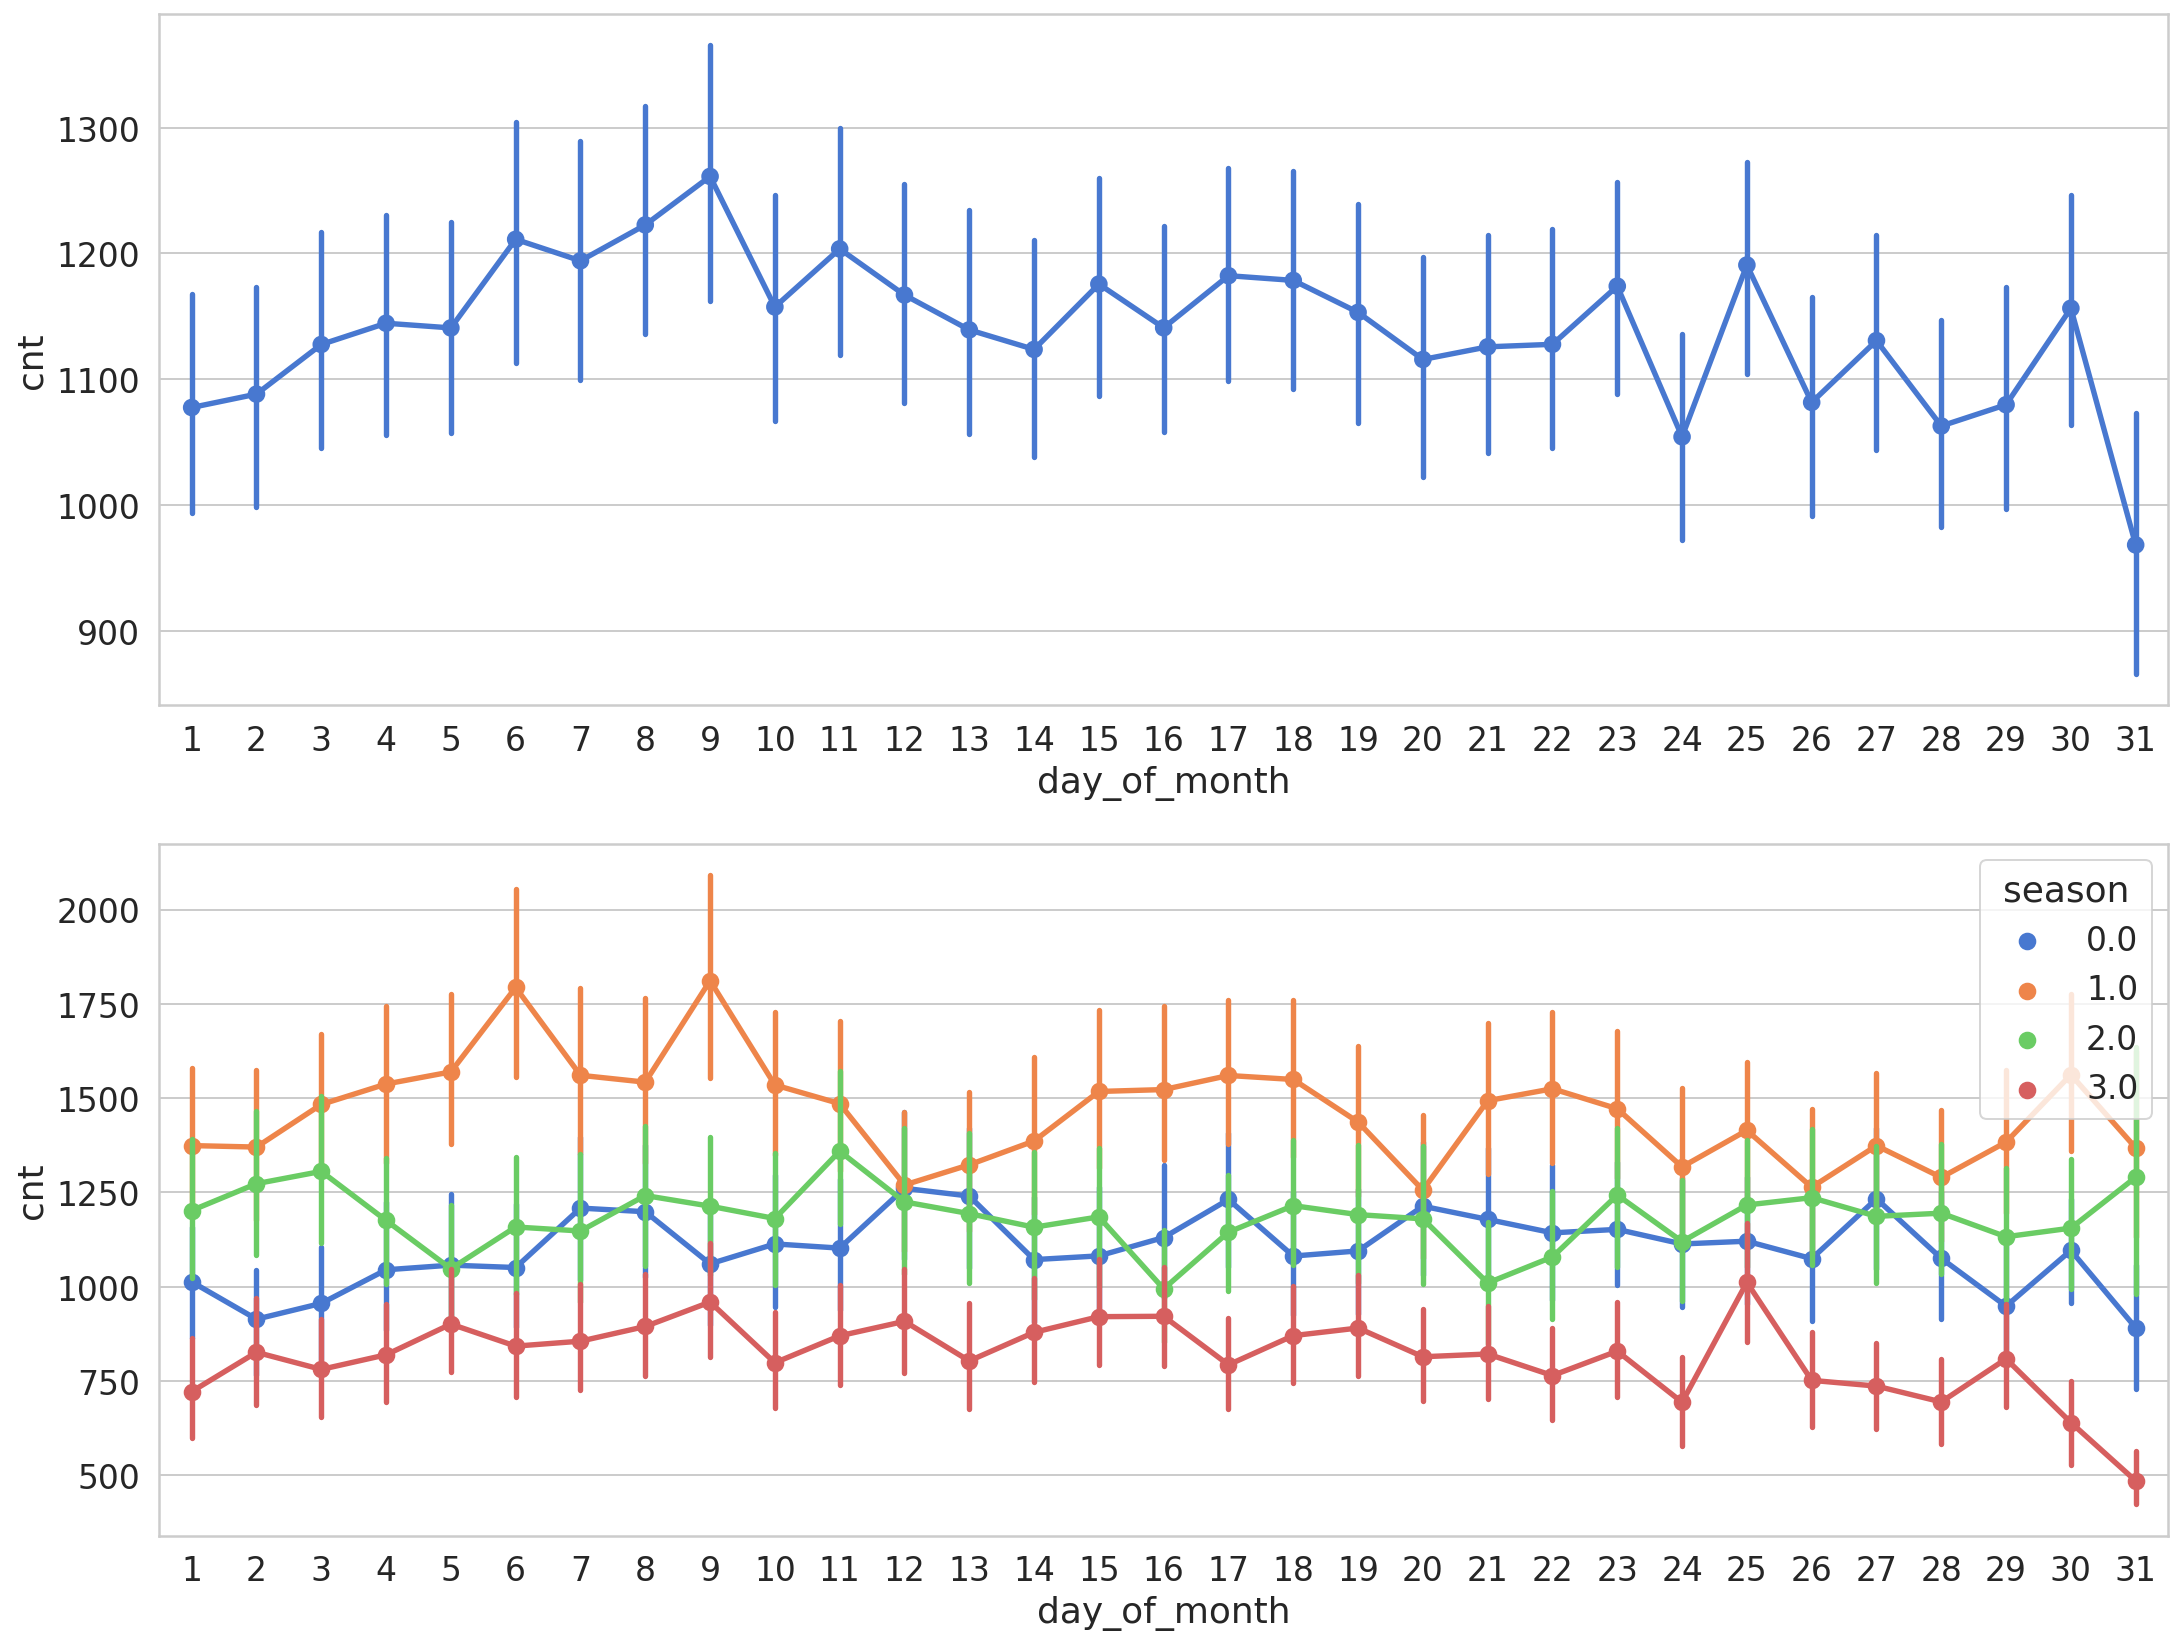

In [ ]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df_pbs, x='day_of_month', y='cnt', ax=ax1)
sns.pointplot(data=df_pbs, x='day_of_month', y='cnt', hue='season', ax=ax2);

**There is a similar pattern between summer and winter**

# Dataset Preparation

In [ ]:
train_size = int(len(df_pbs) * 0.9)
test_size = len(df_pbs) -train_size
train, test = df_pbs.iloc[:train_size], df_pbs.iloc[train_size:]
print(len(train), len(test))

15672 1742


## Transformation

In [ ]:
float_cols = ['t1', 't2', 'hum', 'wind_speed']

float_col_scaler = RobustScaler()
train.loc[:, float_cols] = float_col_scaler.fit_transform(train[float_cols])
test.loc[:, float_cols] = float_col_scaler.transform(test[float_cols])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [ ]:
cnt_transformer = RobustScaler()
train['cnt'] = cnt_transformer.fit_transform(train[['cnt']])
test['cnt'] = cnt_transformer.transform(test[['cnt']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Sequence Mapping

In [ ]:
def create_dataset(X, y, time_steps=1):
  Xs, ys = [], []
  for i in range(len(X) - time_steps):
    v = X.iloc[i:(i + time_steps)].values
    Xs.append(v)
    ys.append(y.iloc[i + time_steps])
  return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 10 # 10 data points from the history:

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(15662, 10, 13) (15662,) (1732, 10, 13) (1732,)


# Modeling

## Utility Function

In [ ]:
# plot model architecture
def plot_model(model):
  model.summary()
  return tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
)

# evaluate model
def evaluate_model(model, history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show();

  print("Evaluation loss",model.evaluate(X_test, y_test))
  y_pred = model.predict(X_test)
  y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
  y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
  y_pred_inv = cnt_transformer.inverse_transform(y_pred)

  rmse = np.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten())) 
  r2 = r2_score(y_test_inv.flatten(),y_pred_inv.flatten()) 
  print("rmse is : {}\nr2 is : {}".format(rmse,r2))

  plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
  plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
  plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
  plt.ylabel('Bike Count')
  plt.xlabel('Time Step')
  plt.legend()
  plt.show();


  plt.plot(y_test_inv.flatten(), marker='.', label="true")
  plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
  plt.ylabel('Bike Count')
  plt.xlabel('Time Step')
  plt.legend()
  plt.show();

In [ ]:
# setting up an early stopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=8,  verbose=1, mode='min')
callbacks_list = [early_stop]

## Vanilla Bi-LSTM BaseLine

In [ ]:
def build_model_lstm_1():
  model = Sequential()
  model.add(Bidirectional(CuDNNLSTM(128), input_shape=(X_train.shape[1], X_train.shape[-1])))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.add(Activation('linear'))
  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              146432    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 146,689
Trainable params: 146,689
Non-trainable params: 0
_________________________________________________________________


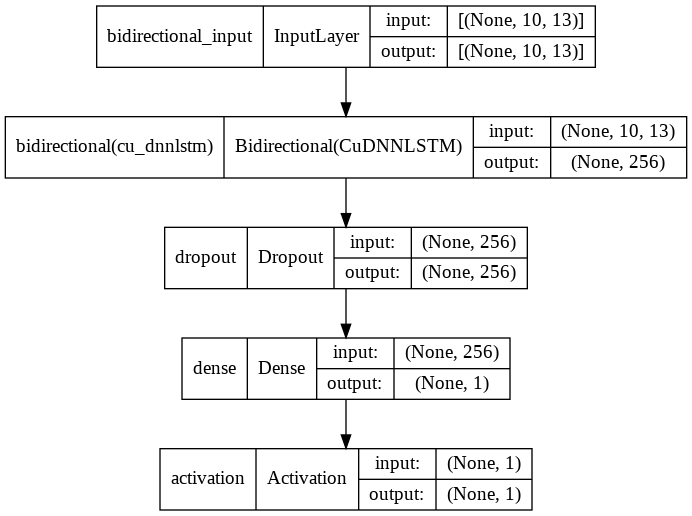

In [ ]:
lstm_vanilla = build_model_lstm_1()
plot_model(lstm_vanilla)

In [ ]:
history_1 = lstm_vanilla.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=128,
                    validation_split=0.1,
                    # callbacks=callbacks_list,
                    shuffle=False)

Epoch 1/30
111/111 [==============================] - 9s 16ms/step - loss: 0.3557 - val_loss: 0.3179
Epoch 2/30
111/111 [==============================] - 1s 11ms/step - loss: 0.2428 - val_loss: 0.1938
Epoch 3/30
111/111 [==============================] - 1s 11ms/step - loss: 0.1709 - val_loss: 0.1079
Epoch 4/30
111/111 [==============================] - 1s 11ms/step - loss: 0.1046 - val_loss: 0.0711
Epoch 5/30
111/111 [==============================] - 1s 11ms/step - loss: 0.0707 - val_loss: 0.0591
Epoch 6/30
111/111 [==============================] - 1s 11ms/step - loss: 0.0594 - val_loss: 0.0528
Epoch 7/30
111/111 [==============================] - 1s 11ms/step - loss: 0.0515 - val_loss: 0.0500
Epoch 8/30
111/111 [==============================] - 1s 11ms/step - loss: 0.0462 - val_loss: 0.0486
Epoch 9/30
111/111 [==============================] - 1s 11ms/step - loss: 0.0420 - val_loss: 0.0501
Epoch 10/30
111/111 [==============================] - 1s 11ms/step - loss: 0.0403 - val_lo

### Evaluation

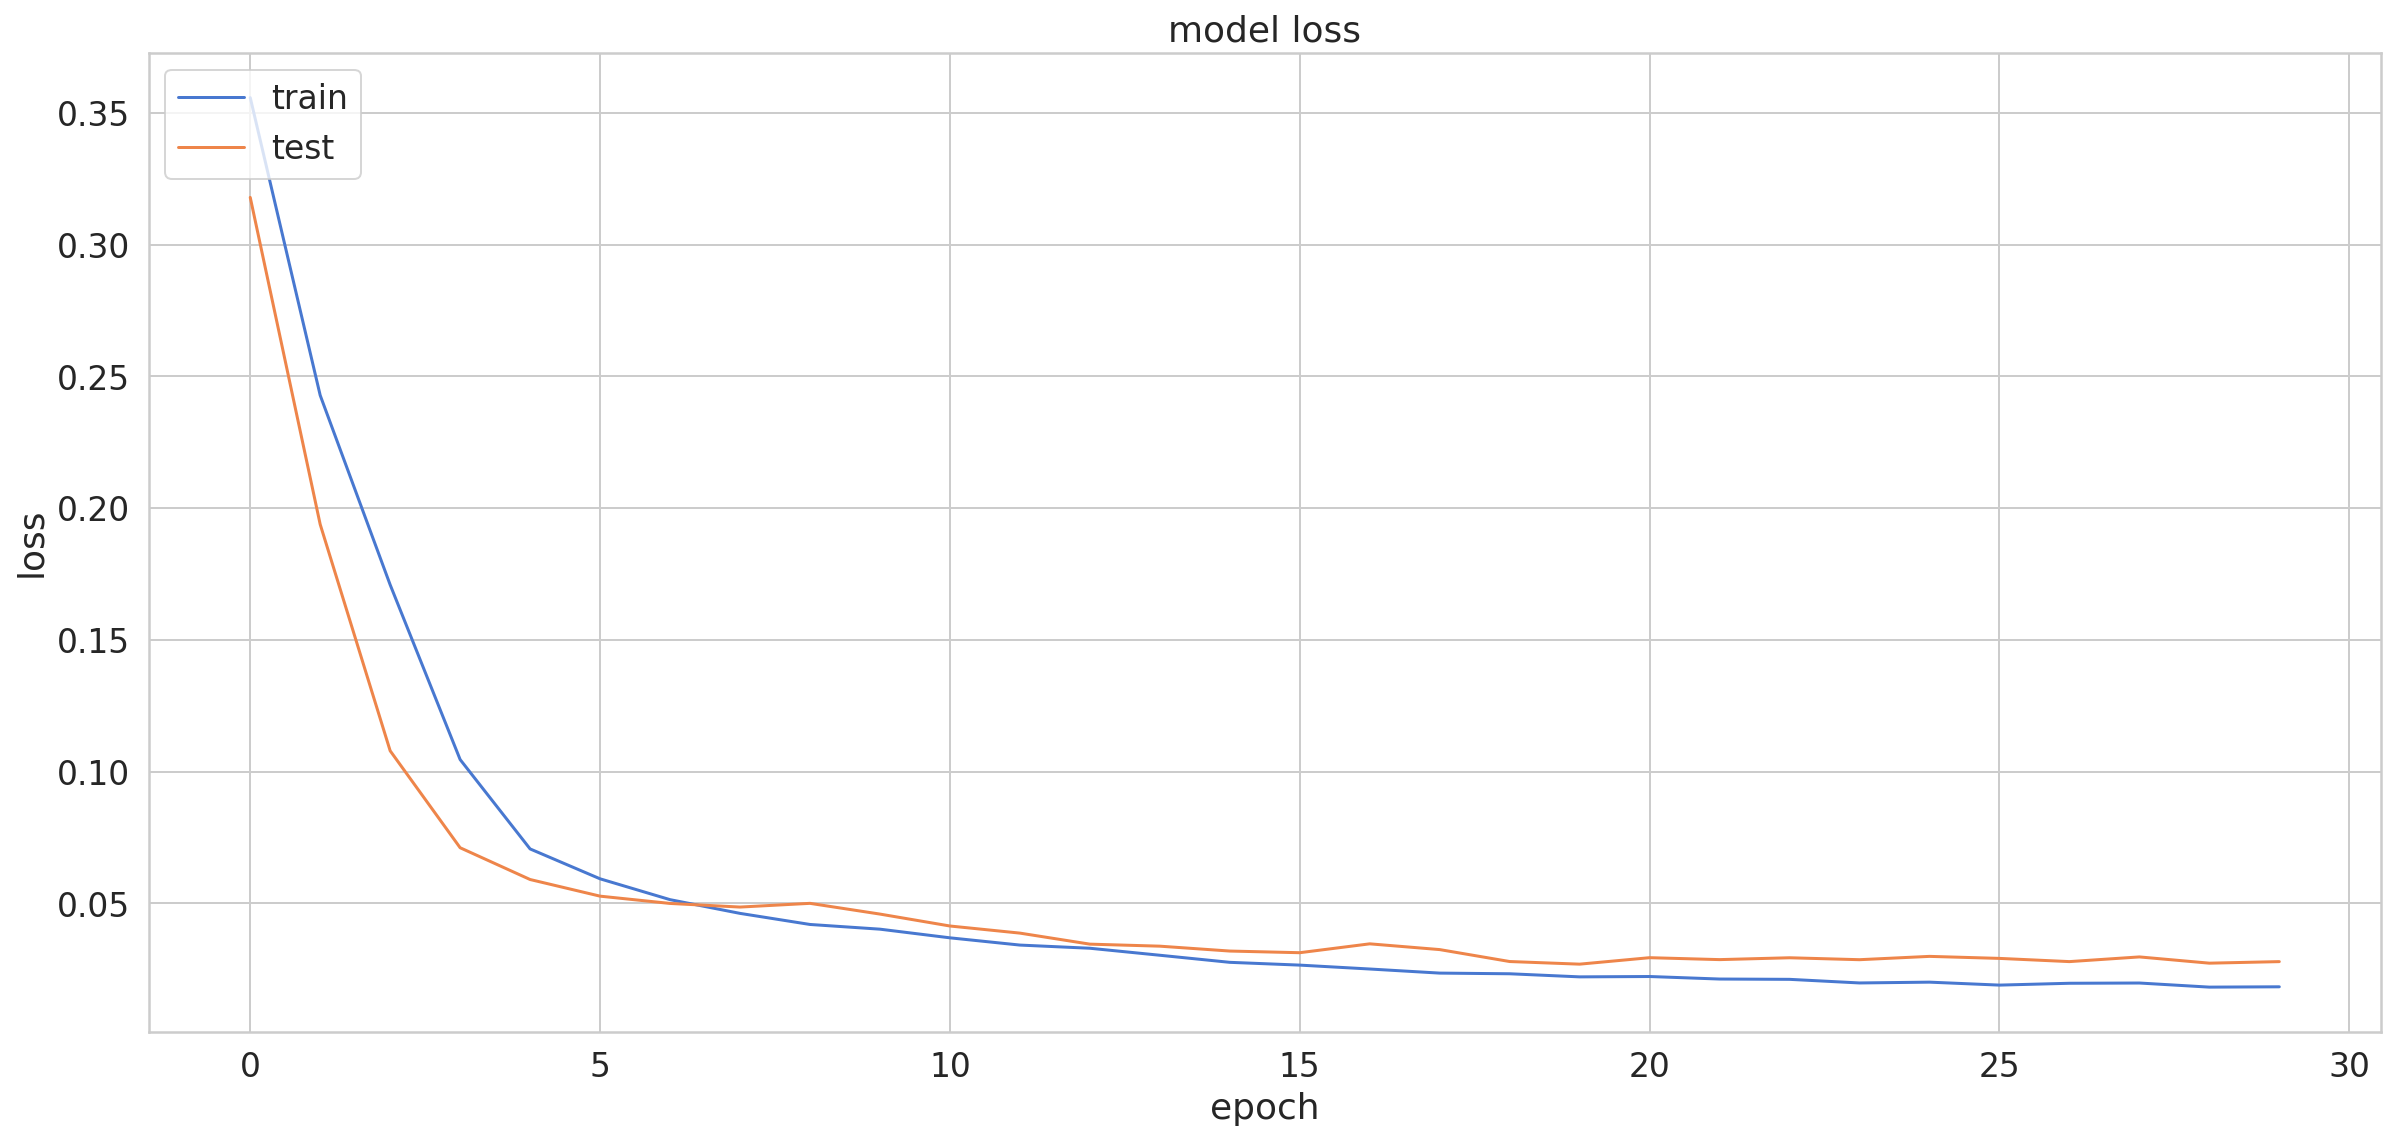

55/55 [==============================] - 0s 6ms/step - loss: 0.0274
Evaluation loss 0.02740301936864853
rmse is : 240.36202598005121
r2 is : 0.9329646041911441


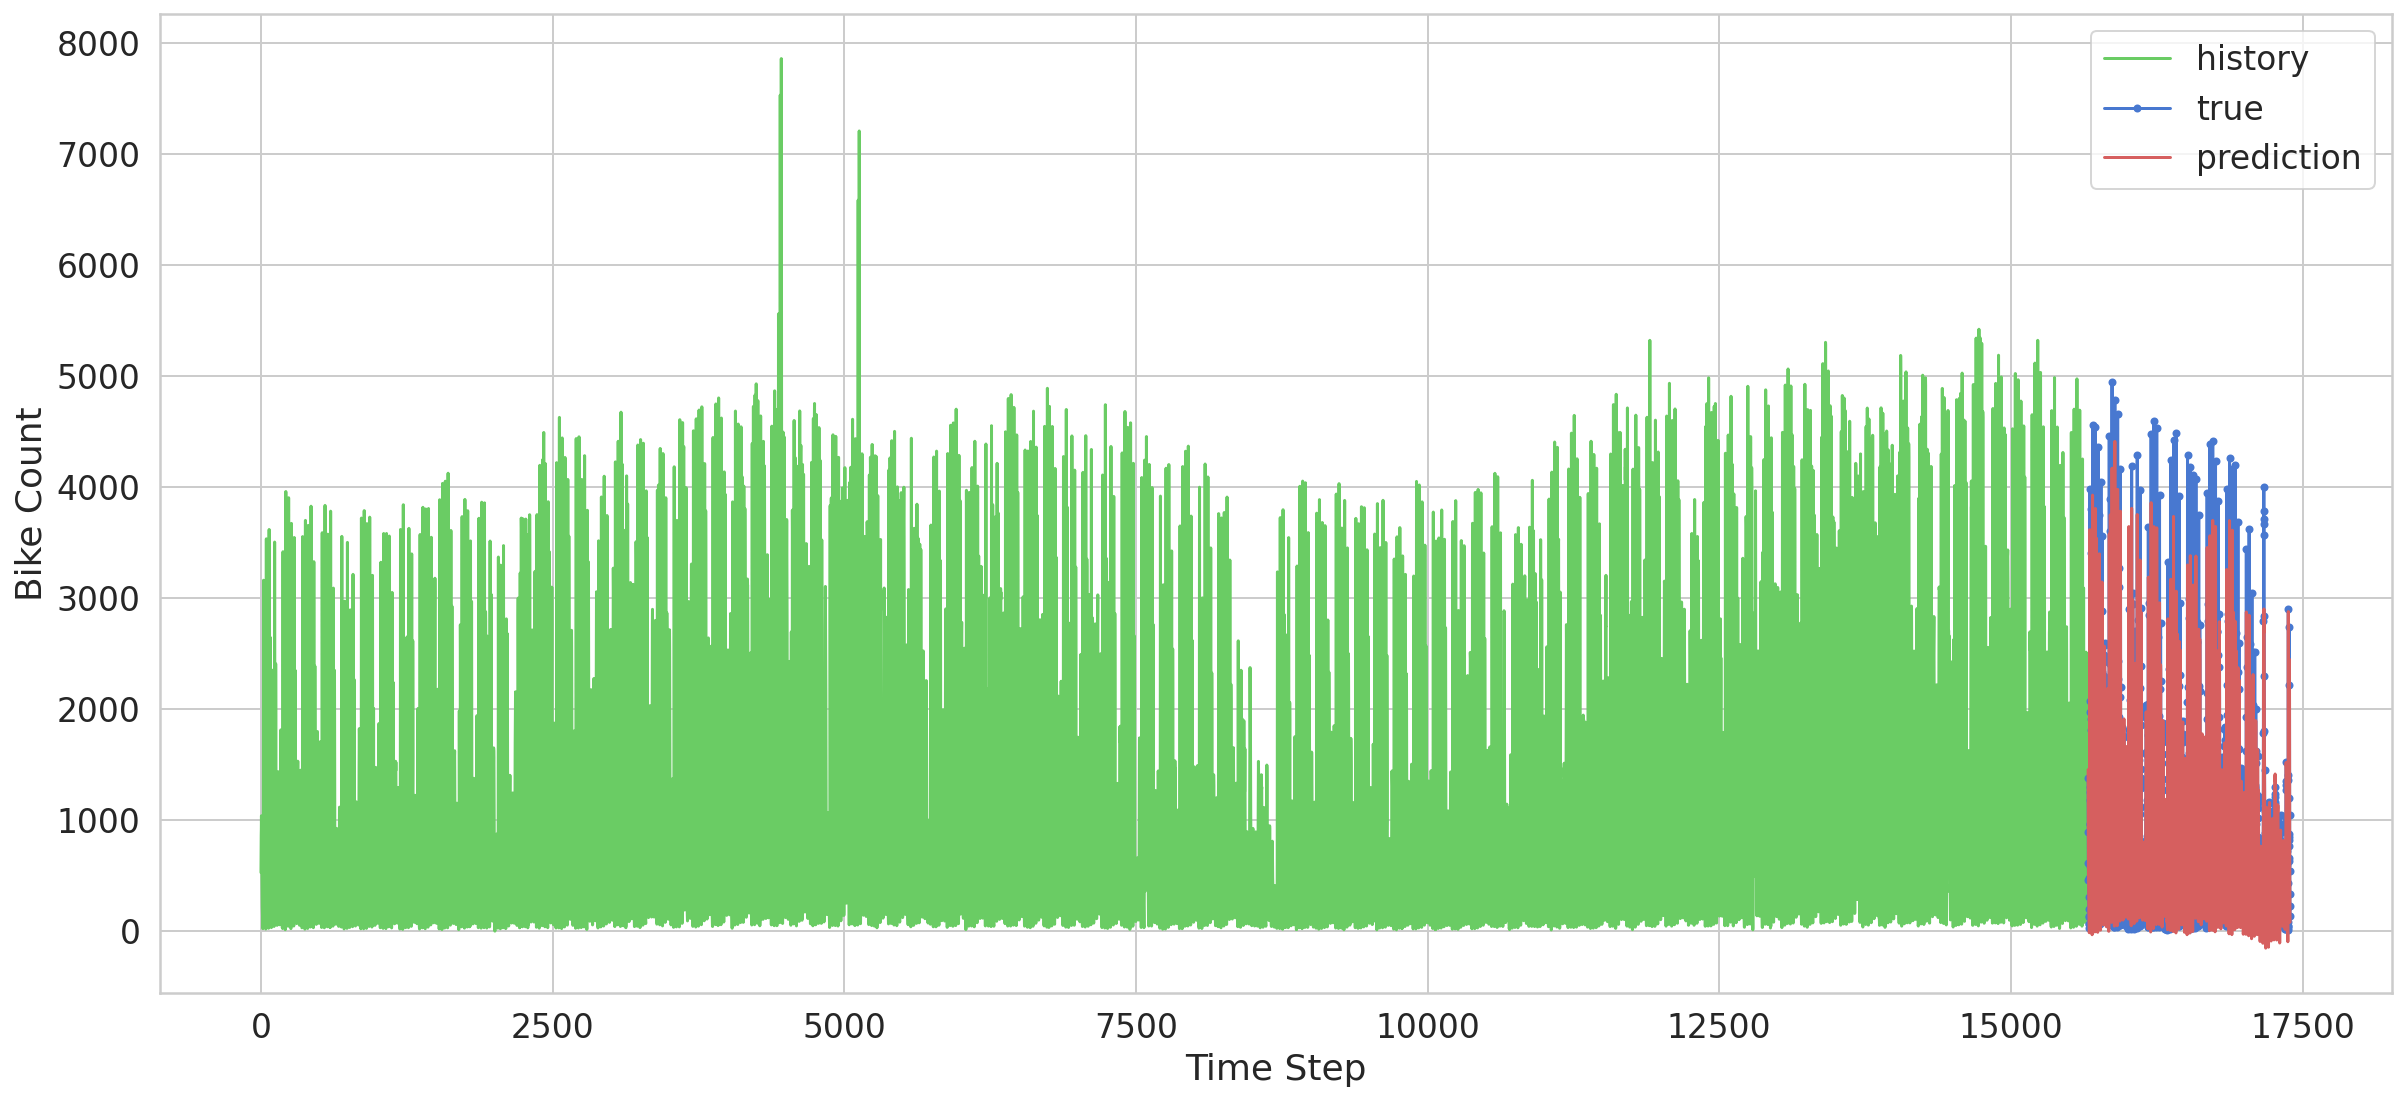

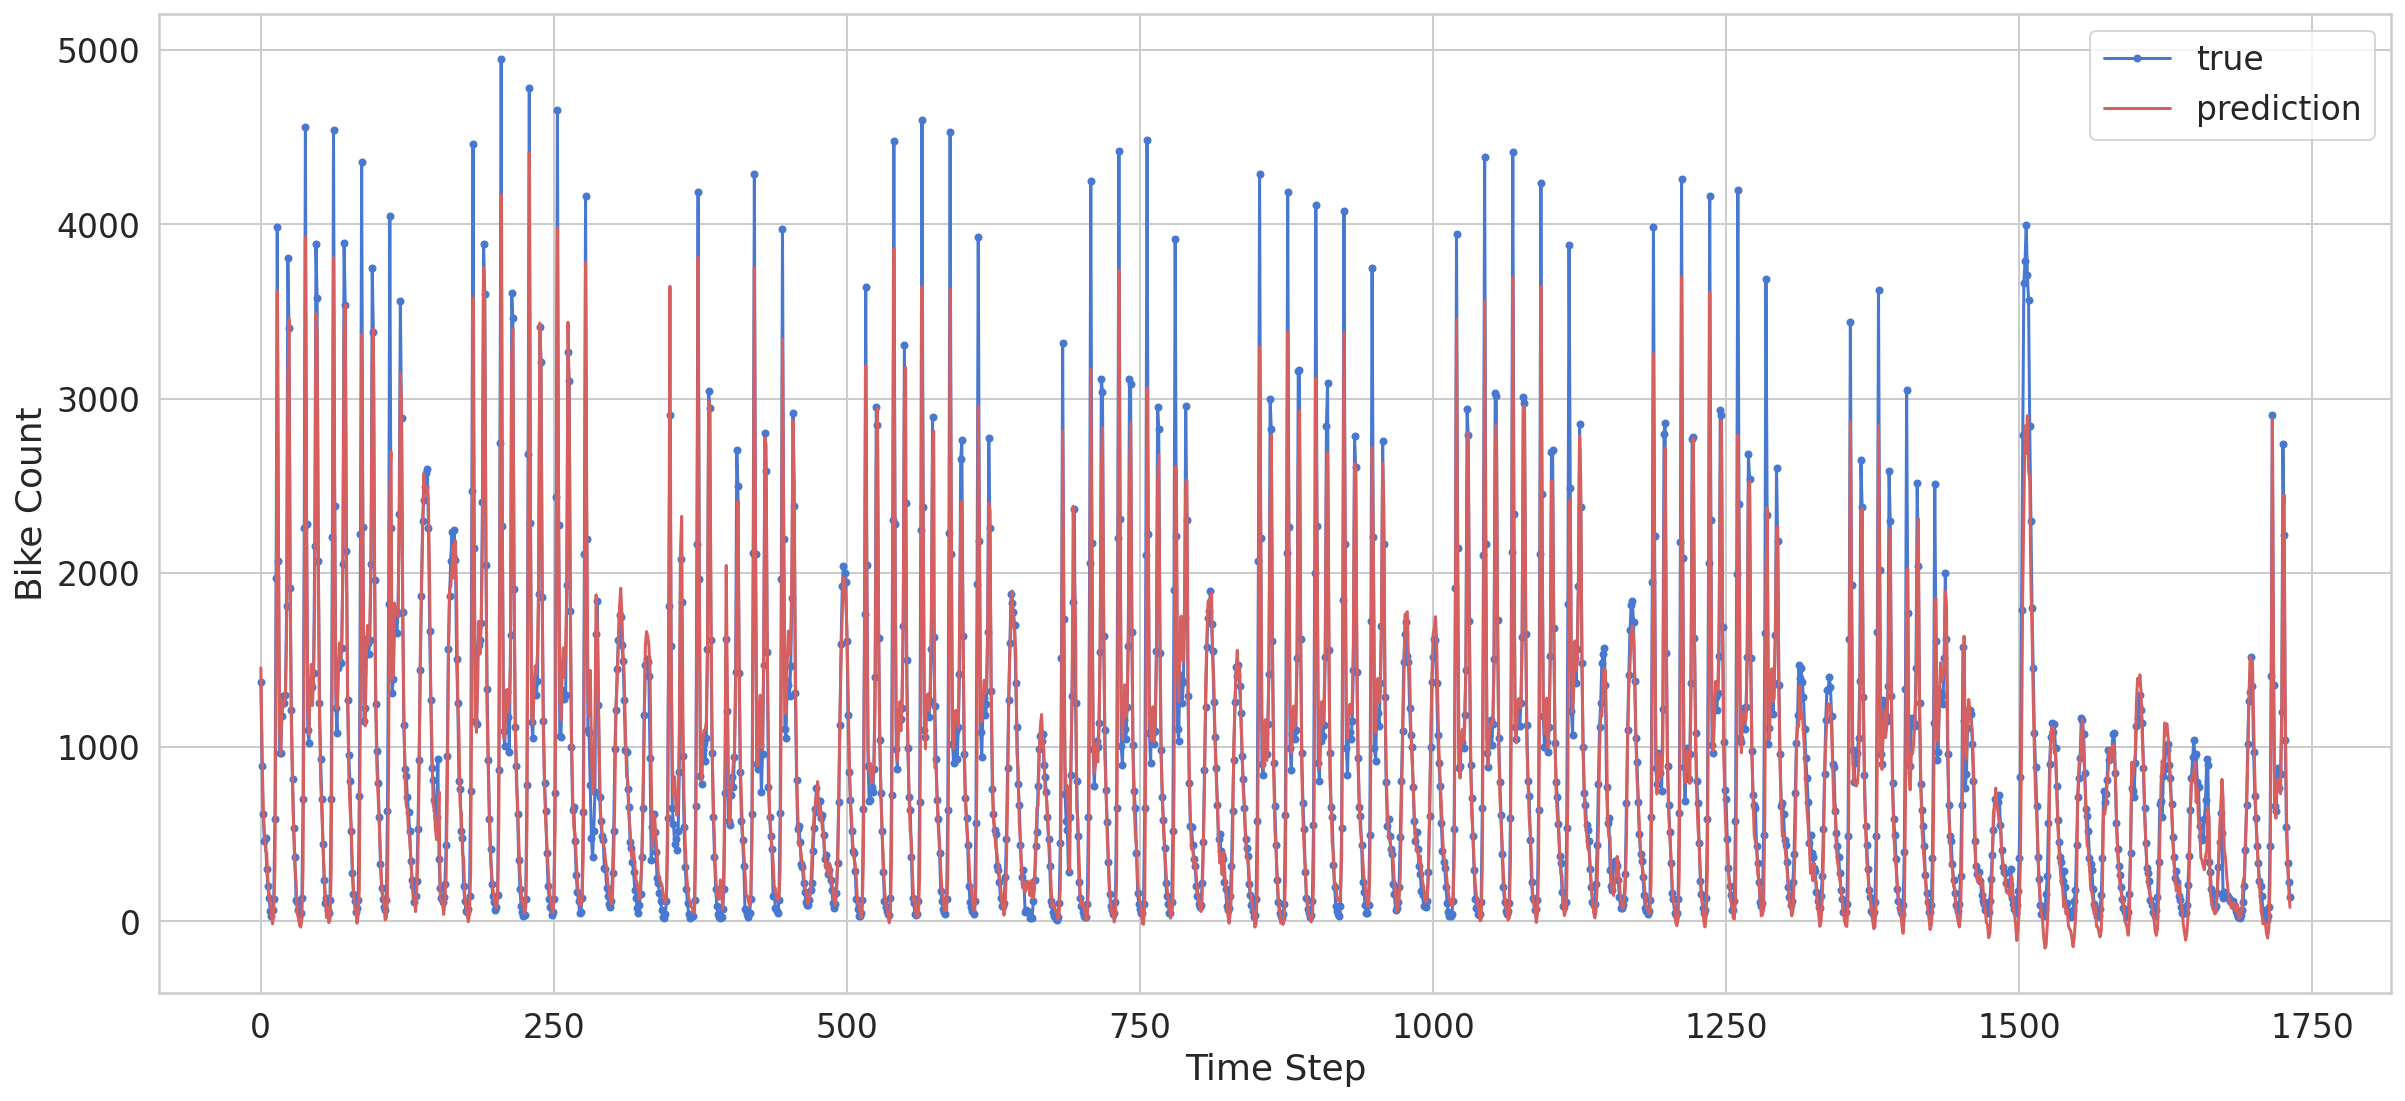

In [ ]:
evaluate_model(lstm_vanilla, history_1)

## Stacked Bi-LSTM 1

Lower weights

In [ ]:
def build_model_lstm_2():
  model = Sequential()
  model.add(Bidirectional(
  CuDNNLSTM(X_train.shape[1], return_sequences=True), 
  input_shape=(X_train.shape[1], X_train.shape[-1])
  ))

  model.add(Dropout(0.2))
  model.add(Bidirectional(CuDNNLSTM((X_train.shape[1] * 2), 
                                              return_sequences=True)))
  model.add(Dropout(0.2))

  model.add(Bidirectional(CuDNNLSTM(X_train.shape[1])))

  model.add(Dense(units=1))
  model.add(Activation('linear'))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 10, 20)           2000      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 20)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 10, 40)           6720      
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 10, 40)            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 20)               4160      
 nal)                                                            
                                                      

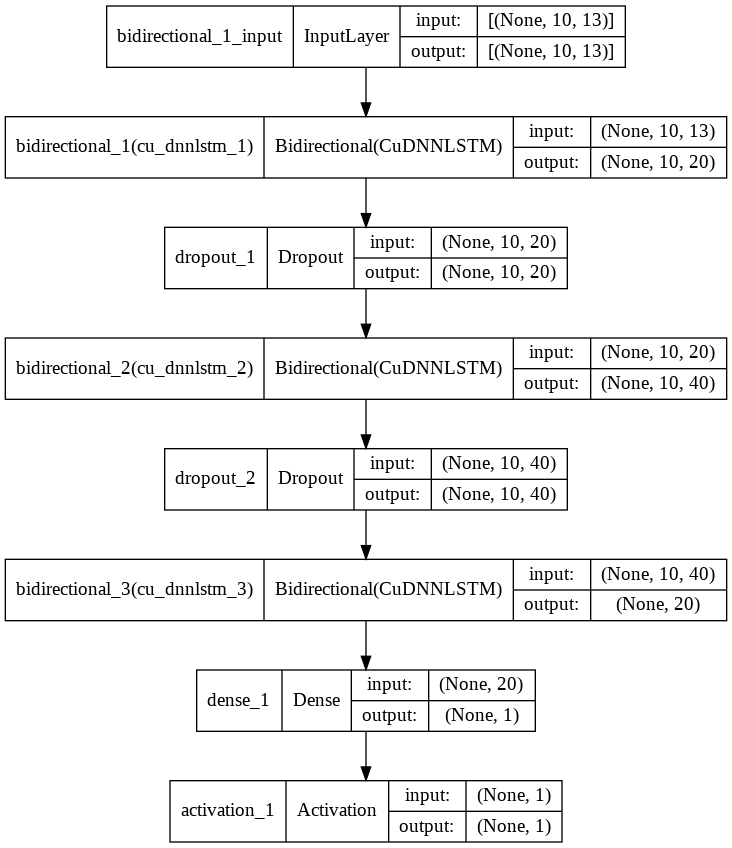

In [ ]:
lstm_stacked_1 = build_model_lstm_2()
plot_model(lstm_stacked_1)

In [ ]:
history_2 = lstm_stacked_1.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=64,
                    validation_split=0.1,
                    shuffle=False)

Epoch 1/30
221/221 [==============================] - 12s 35ms/step - loss: 0.3568 - val_loss: 0.3499
Epoch 2/30
221/221 [==============================] - 7s 31ms/step - loss: 0.2339 - val_loss: 0.2282
Epoch 3/30
221/221 [==============================] - 7s 31ms/step - loss: 0.1635 - val_loss: 0.1789
Epoch 4/30
221/221 [==============================] - 7s 31ms/step - loss: 0.1243 - val_loss: 0.1454
Epoch 5/30
221/221 [==============================] - 7s 31ms/step - loss: 0.1043 - val_loss: 0.1069
Epoch 6/30
221/221 [==============================] - 7s 31ms/step - loss: 0.0959 - val_loss: 0.0878
Epoch 7/30
221/221 [==============================] - 7s 30ms/step - loss: 0.0856 - val_loss: 0.0751
Epoch 8/30
221/221 [==============================] - 7s 30ms/step - loss: 0.0804 - val_loss: 0.0759
Epoch 9/30
221/221 [==============================] - 7s 31ms/step - loss: 0.0744 - val_loss: 0.0712
Epoch 10/30
221/221 [==============================] - 7s 30ms/step - loss: 0.0681 - val_l

### Evaluation

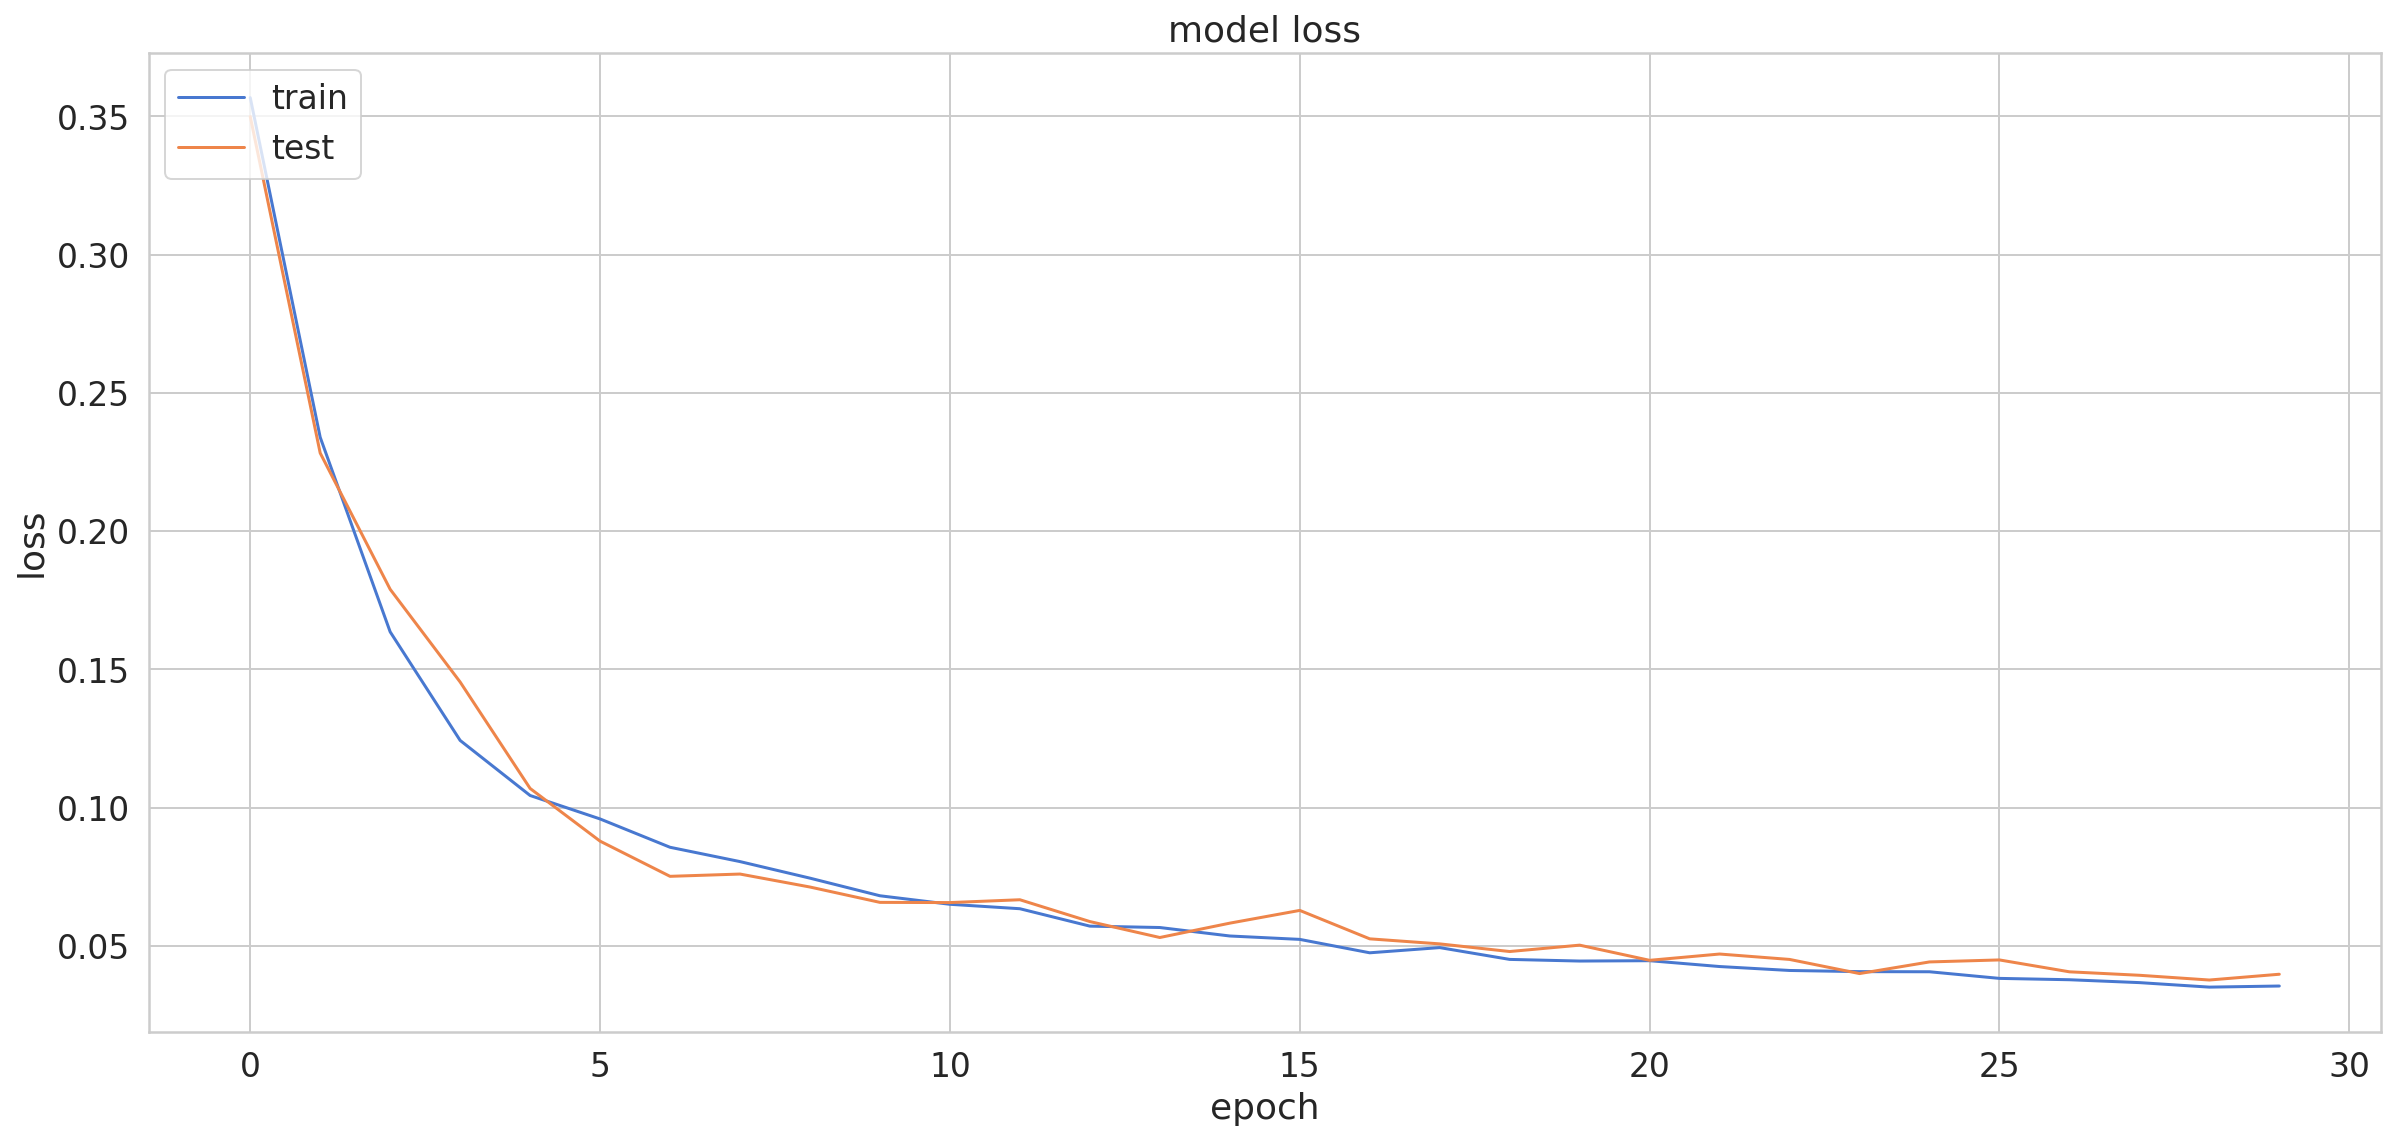

55/55 [==============================] - 1s 10ms/step - loss: 0.0336
Evaluation loss 0.03360838443040848
rmse is : 266.18919691370223
r2 is : 0.9177845727498675


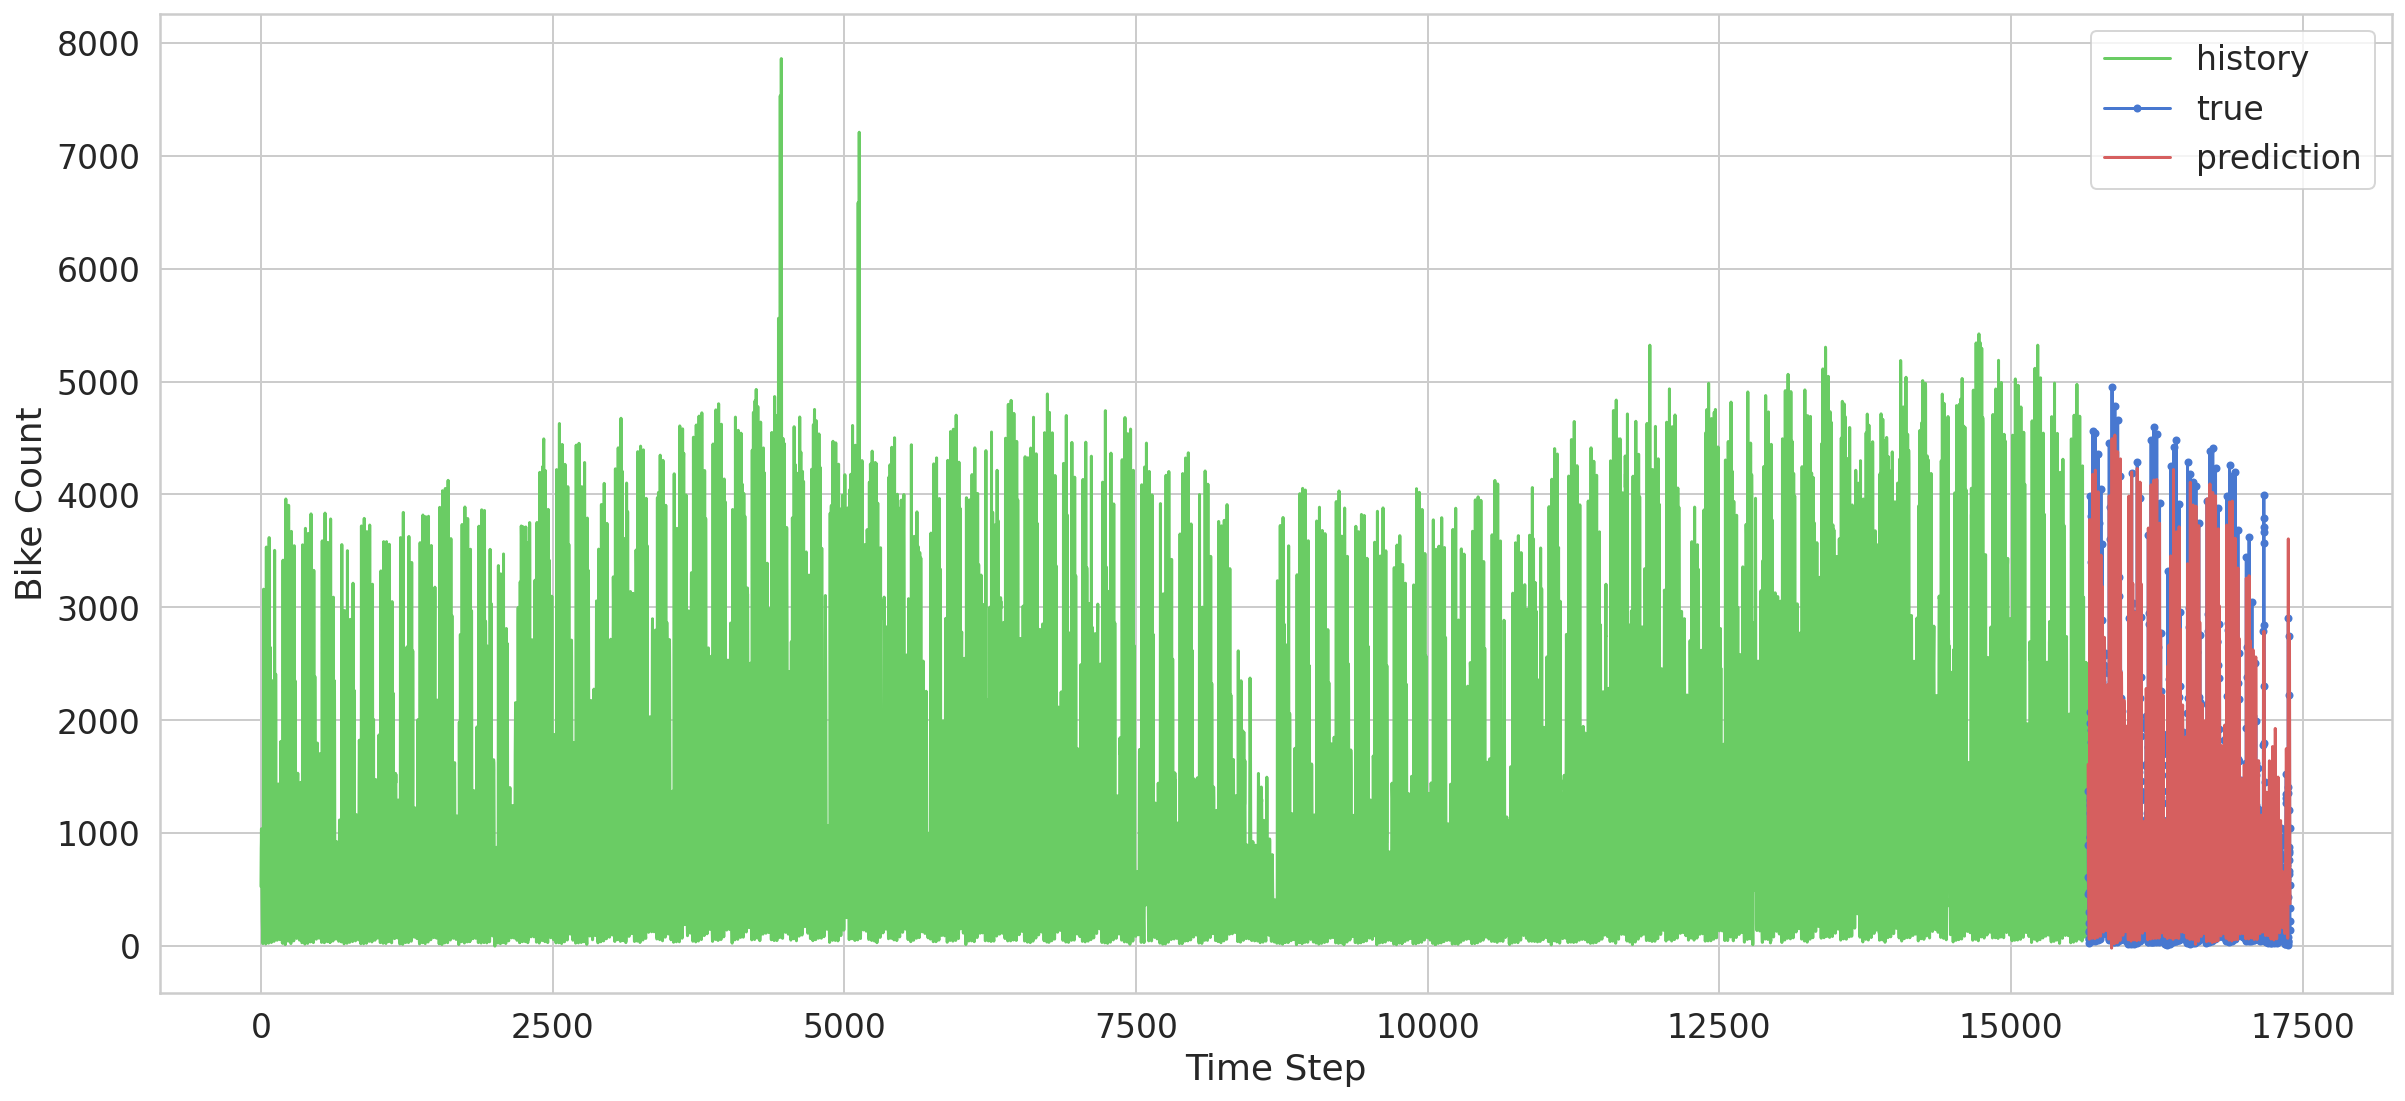

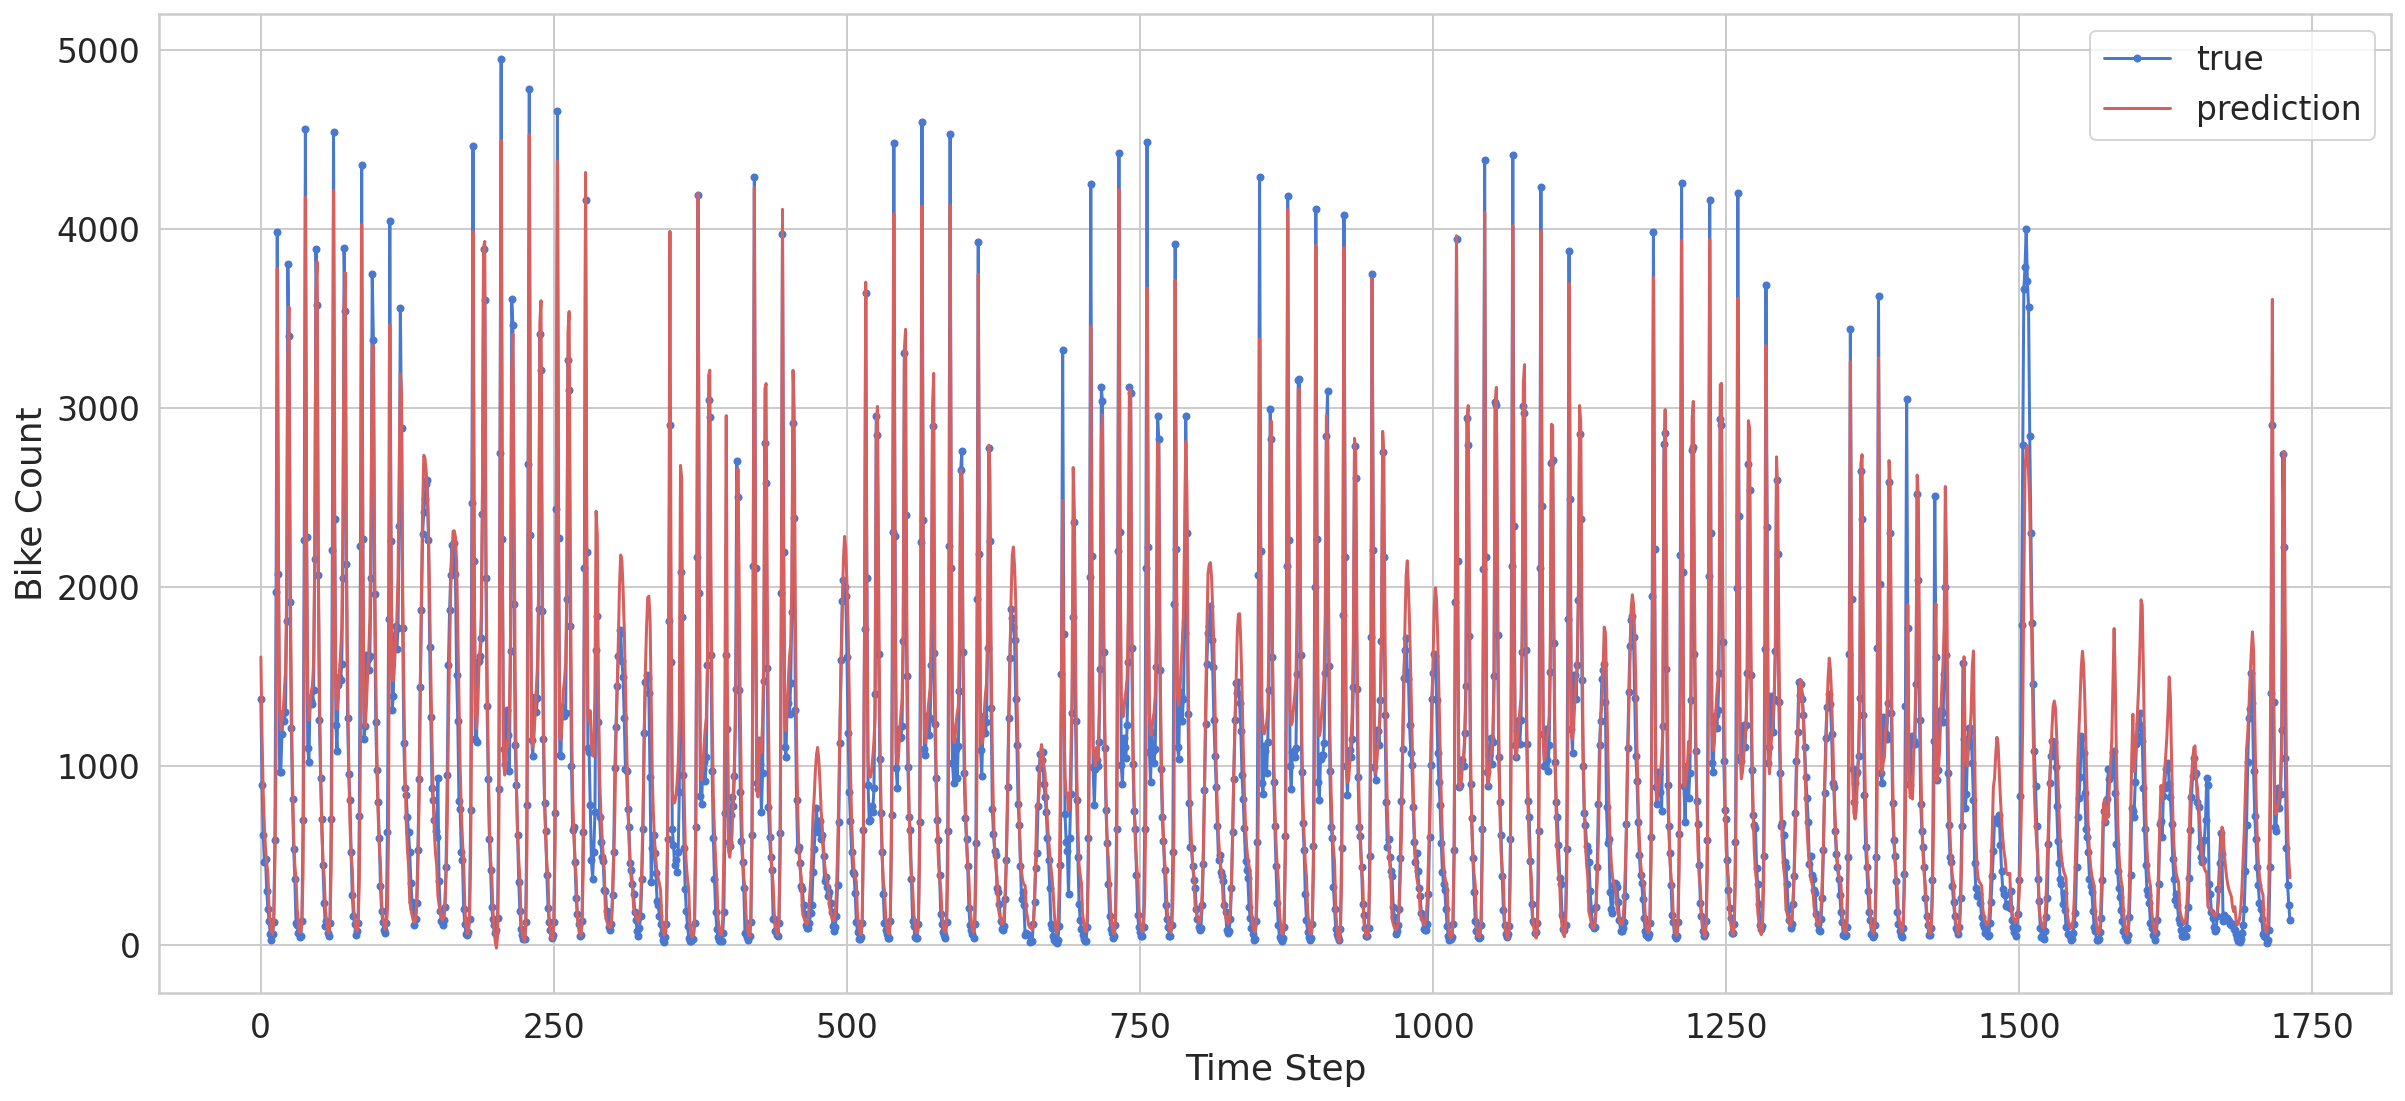

In [ ]:
evaluate_model(lstm_stacked_1, history_2)

## Stacked Bi-LSTM 2


In [ ]:
def build_model_lstm_3():
  model = Sequential()
  model.add(Bidirectional(
  CuDNNLSTM(32, return_sequences=True), 
  input_shape=(X_train.shape[1], X_train.shape[-1])
  ))

  model.add(Dropout(0.2))
  model.add(Bidirectional(CuDNNLSTM((32), 
                                              return_sequences=True)))
  model.add(Dropout(0.2))

  model.add(Bidirectional(CuDNNLSTM(16)))

  model.add(Dense(units=1))
  model.add(Activation('linear'))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 10, 64)           12032     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 10, 64)            0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 10, 64)           25088     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 10, 64)            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 32)               10496     
 nal)                                                            
                                                      

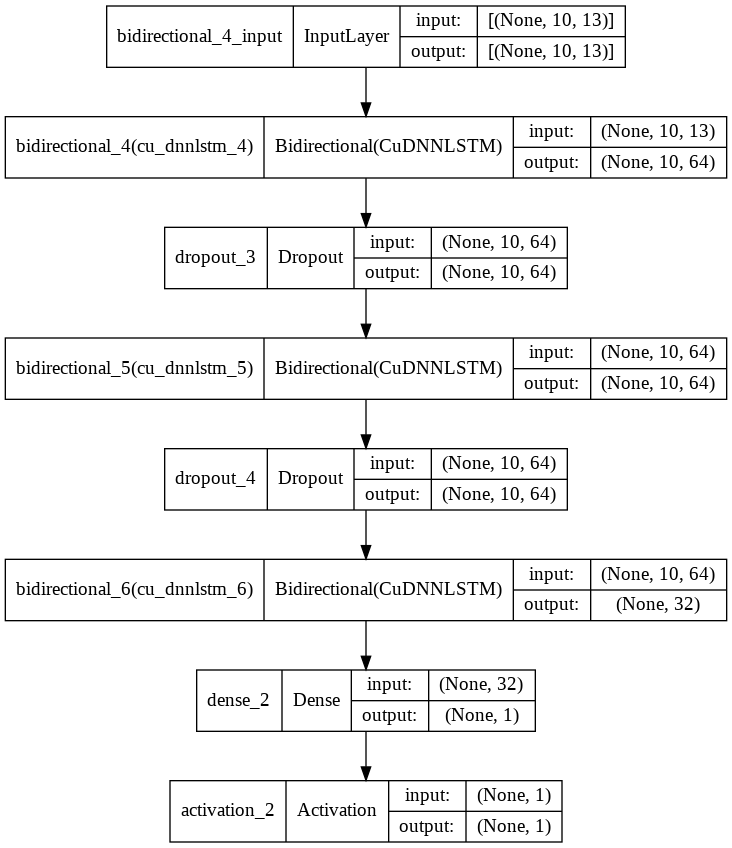

In [ ]:
lstm_stacked_2 = build_model_lstm_3()
plot_model(lstm_stacked_2)

In [ ]:
history_3 = lstm_stacked_2.fit(X_train, y_train, 
                    epochs=40,
                    batch_size=64,
                    validation_split=0.1,
                    shuffle=False)

Epoch 1/40
221/221 [==============================] - 12s 32ms/step - loss: 0.2941 - val_loss: 0.1769
Epoch 2/40
221/221 [==============================] - 6s 28ms/step - loss: 0.1531 - val_loss: 0.2352
Epoch 3/40
221/221 [==============================] - 6s 28ms/step - loss: 0.1172 - val_loss: 0.1203
Epoch 4/40
221/221 [==============================] - 6s 28ms/step - loss: 0.0820 - val_loss: 0.0782
Epoch 5/40
221/221 [==============================] - 6s 28ms/step - loss: 0.0708 - val_loss: 0.0752
Epoch 6/40
221/221 [==============================] - 6s 28ms/step - loss: 0.0657 - val_loss: 0.0635
Epoch 7/40
221/221 [==============================] - 6s 28ms/step - loss: 0.0612 - val_loss: 0.0656
Epoch 8/40
221/221 [==============================] - 6s 28ms/step - loss: 0.0572 - val_loss: 0.0764
Epoch 9/40
221/221 [==============================] - 6s 28ms/step - loss: 0.0546 - val_loss: 0.0621
Epoch 10/40
221/221 [==============================] - 6s 28ms/step - loss: 0.0487 - val_l

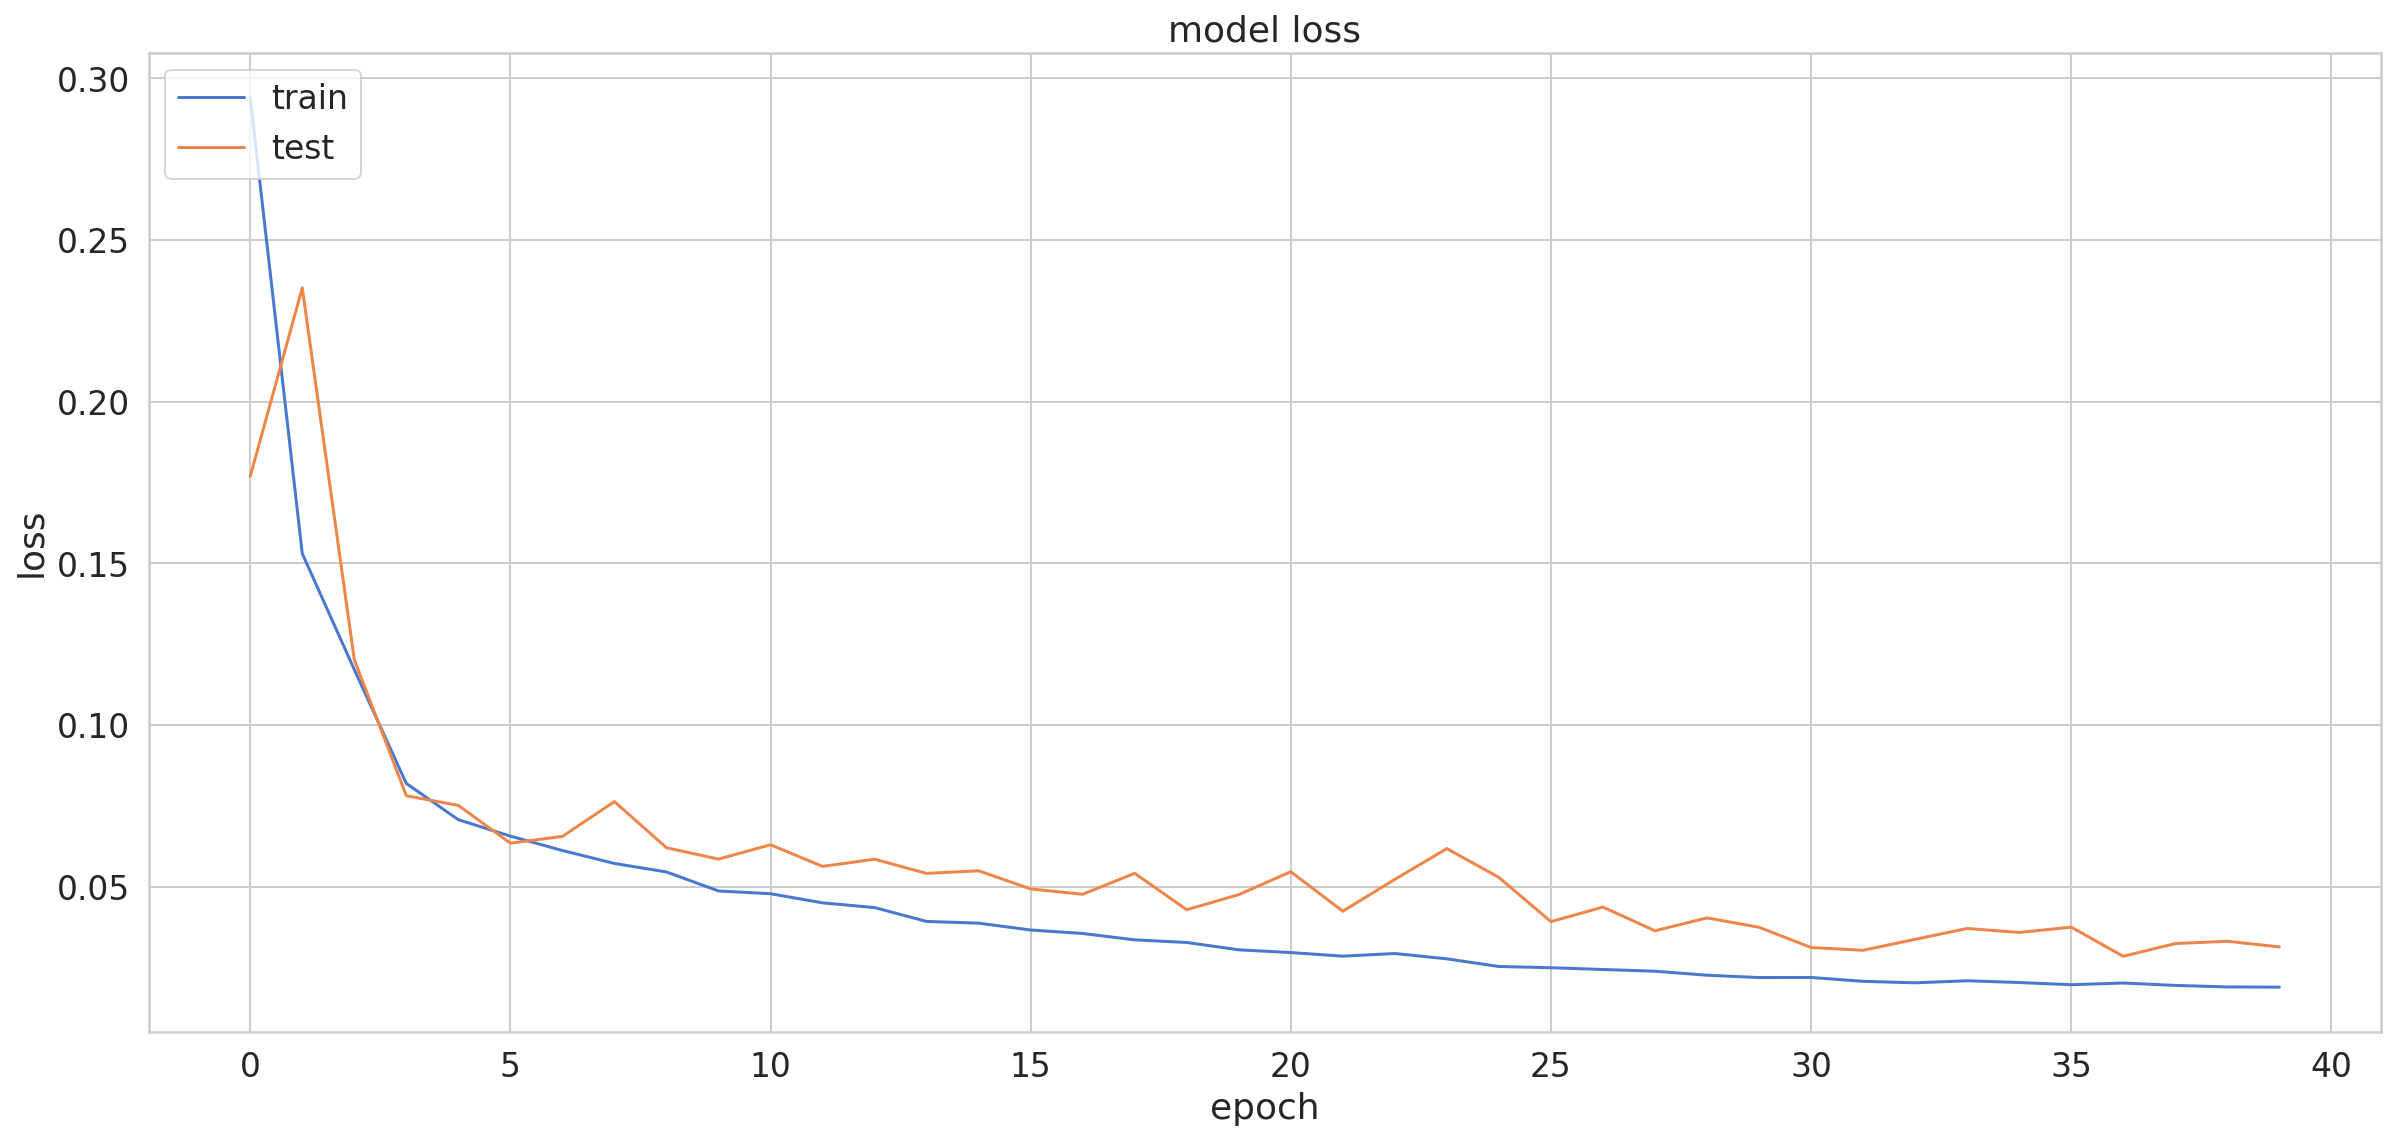

55/55 [==============================] - 1s 10ms/step - loss: 0.0564
Evaluation loss 0.056376293301582336
rmse is : 344.75838654703443
r2 is : 0.8620879718814071


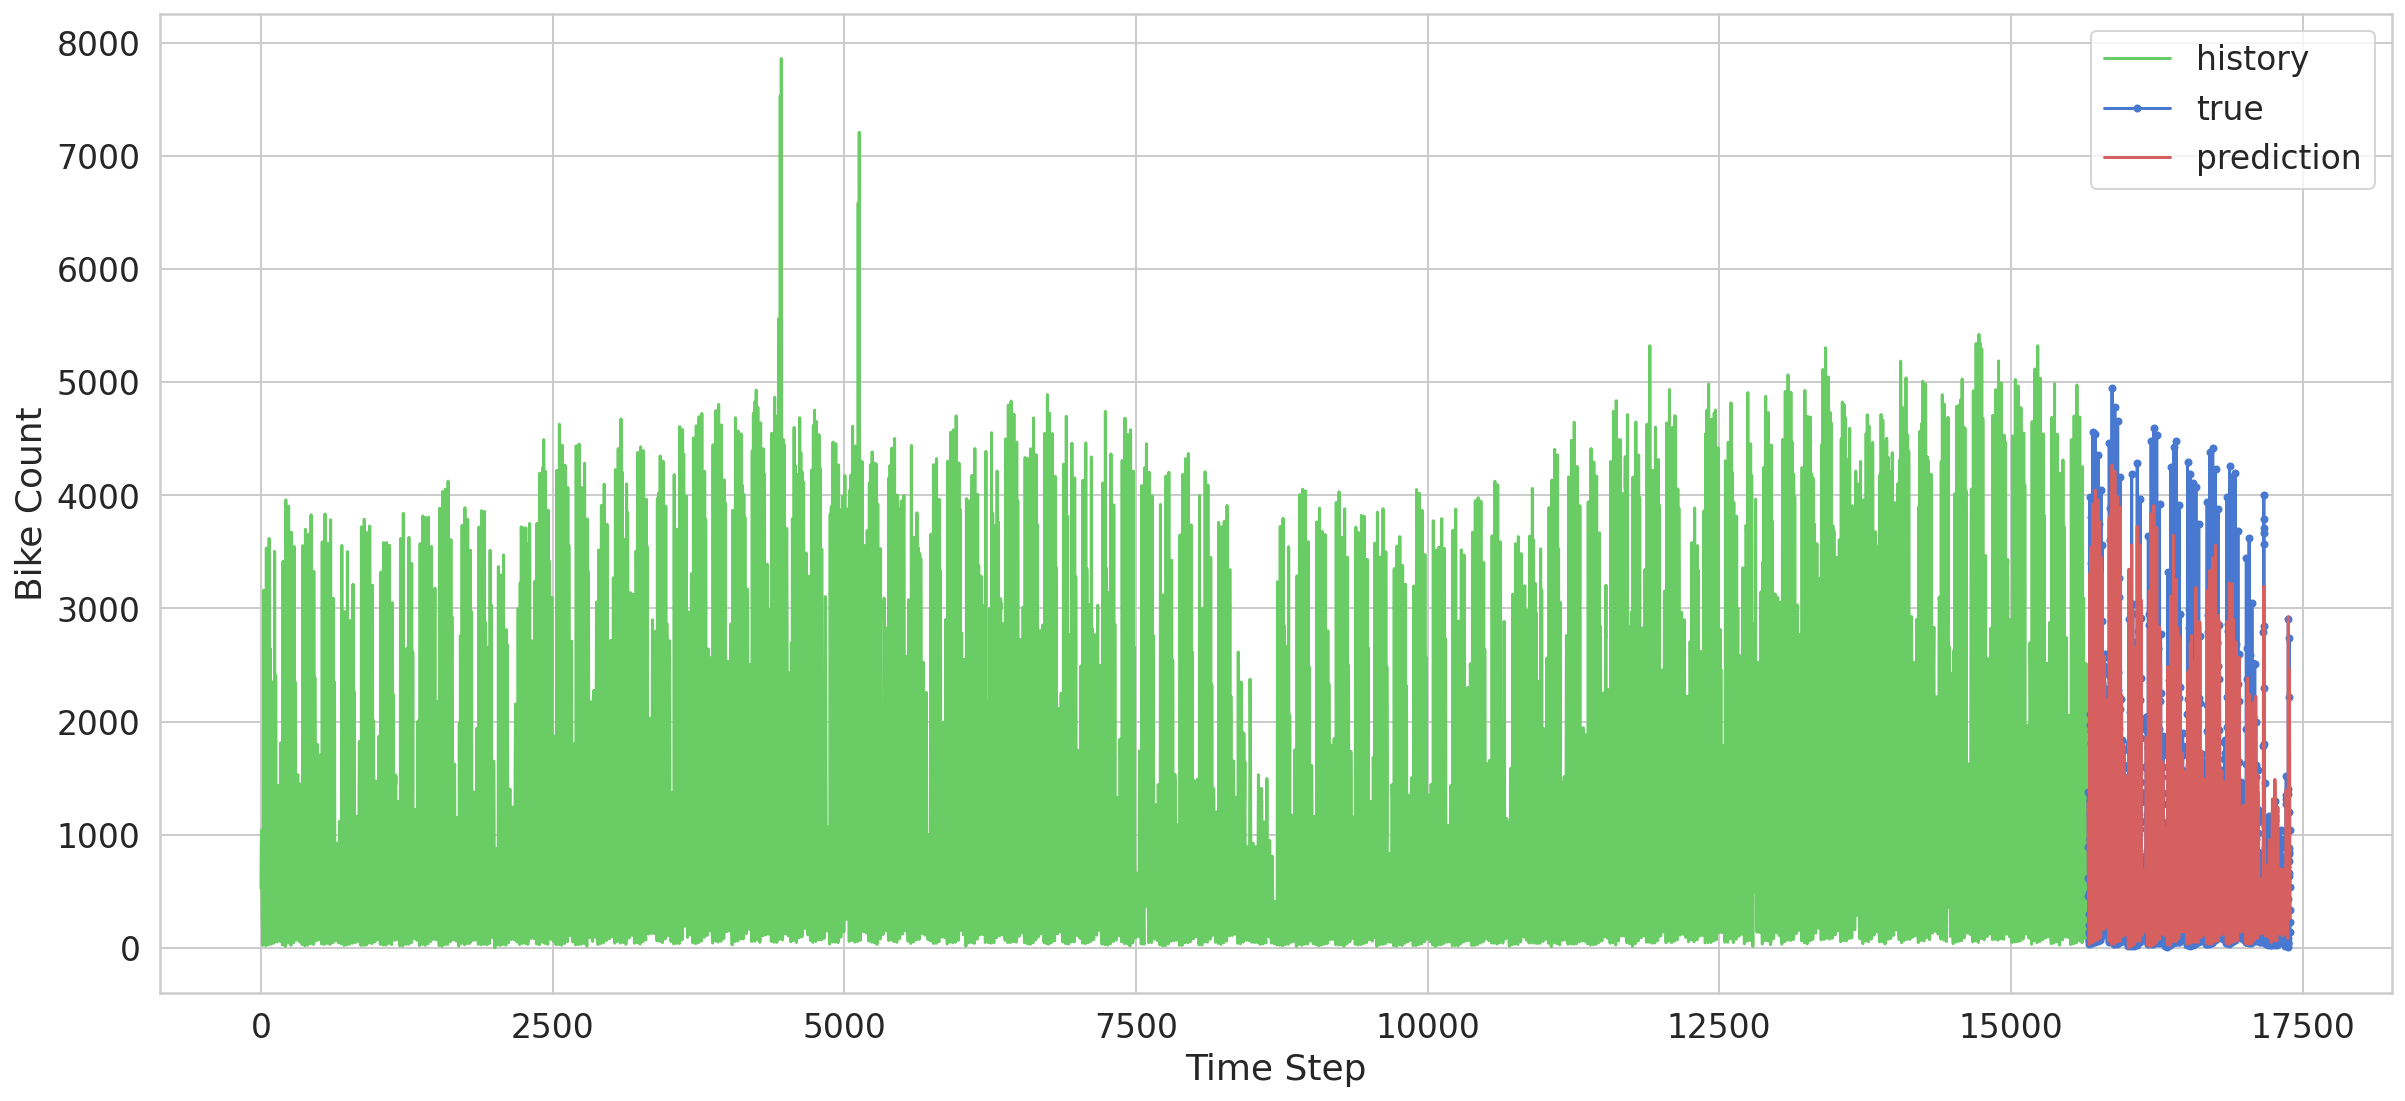

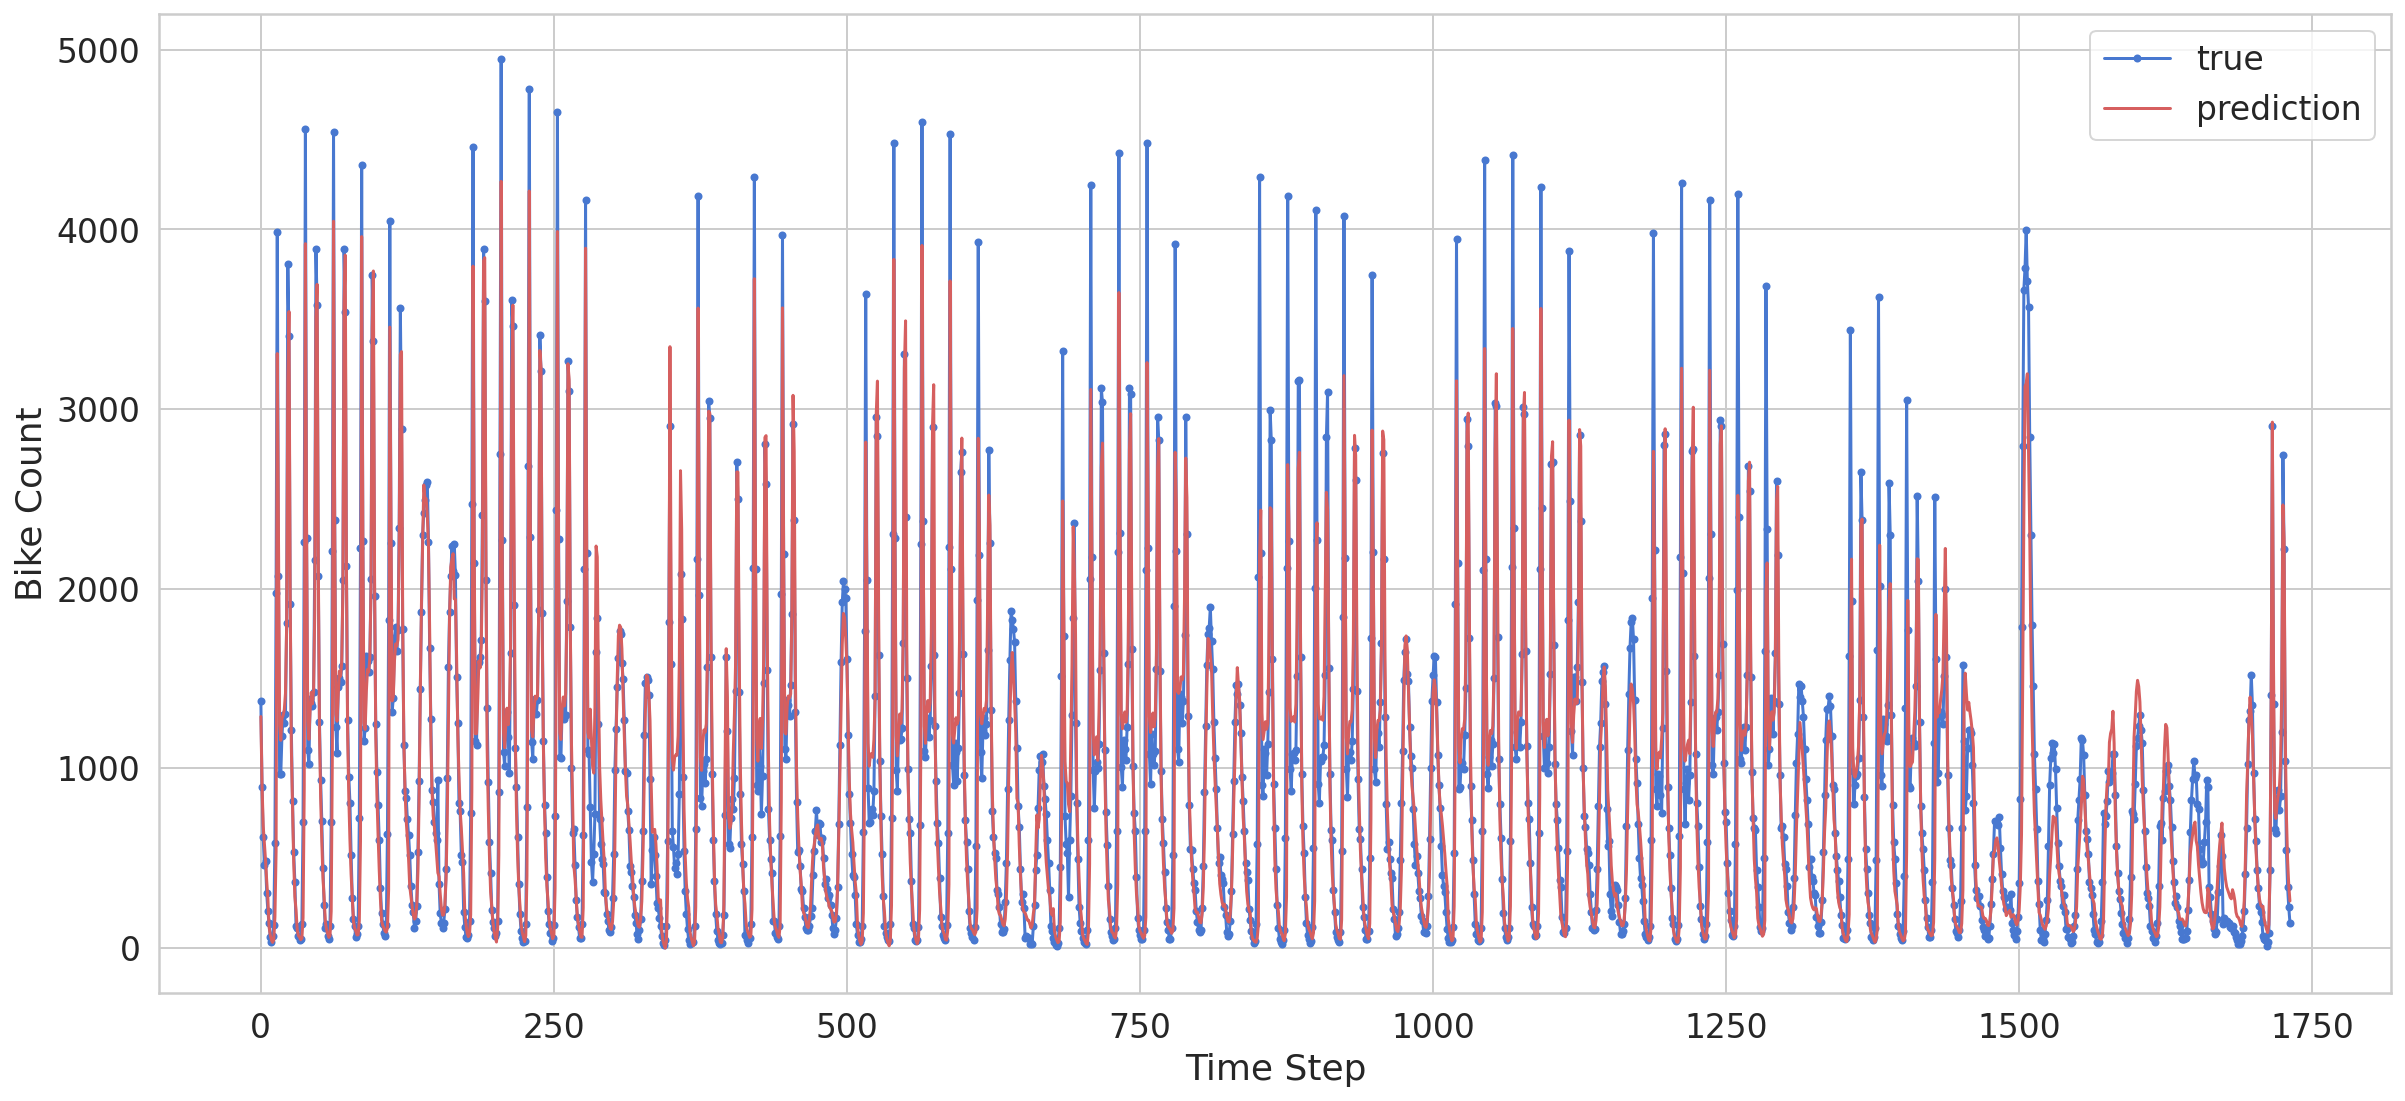

In [ ]:
evaluate_model(lstm_stacked_2, history_3)